In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 4.3 MB/s eta 0:00:00


In [ ]:
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

RANDOM_SEED = 42
BASE = '/content/drive/MyDrive/Univerui/Bakalauras/'

import pandas as pd
import numpy as np

train_df = pd.read_csv(BASE+'train_data.csv')
test_df = pd.read_csv(BASE+'test_data.csv')
X_train_fs = pd.read_csv(BASE+'Train_Features.csv')
X_test_fs = pd.read_csv(BASE+'Test_Features.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
X_train, y_train = train_df.drop('attack', axis=1), train_df.attack
X_test, y_test = test_df.drop('attack', axis=1), test_df.attack

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import optuna
labels = ['Ataka', 'Normalus']

# Helper Functions

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.light_palette("seagreen", as_cmap=True)

def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  
  plt.figure(1, figsize=(4,4))
  axis = sns.heatmap(cm, annot=True, cbar=False, cmap='Greens', fmt='d')

  axis.set_xticklabels(labels)
  axis.set_yticklabels(labels)

  axis.set(ylabel='Tikros reikšmės', xlabel='Prognozuotos reikšmės')

  plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
def plot_auc(y_true, y_pred):
  fpr, tpr, thresholds = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(5,5))
  plt.plot(fpr,tpr, color='green',label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],linestyle='--', color='grey')
  plt.axis('tight')
  plt.ylabel('True Positive')
  plt.xlabel('False Positive')

In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='Treniravimo nuostoliai')
  plt.plot(epochs, val_loss, label='Validavimo nuostoliai')
  plt.title('Nuostoliai')
  plt.xlabel('Epochos')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='Treniravimo teisingumas')
  plt.plot(epochs, val_accuracy, label='Validavimo teisingumas')
  plt.title('Teisingumas')
  plt.xlabel('Epochos')
  plt.legend();

# Standart evaluation

## Random Class Limit

In [ ]:
rcl = np.random.randint(2, size=y_test.shape[0])
calculate_results(y_test, rcl)

{'accuracy': 49.97338537970192,
 'precision': 0.5091326071686798,
 'recall': 0.4997338537970192,
 'f1': 0.5021434530846252}

## Major Class Limit

In [ ]:
mcl = np.zeros_like(y_test)
calculate_results(y_test, mcl)

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 56.92423704755145,
 'precision': 0.32403687634458295,
 'recall': 0.5692423704755145,
 'f1': 0.41298512255489606}

# Modeling Experimentations, Before Feature Selection

## SVC

### Base parameters

In [ ]:
from sklearn.svm import SVC

svc_model = SVC()

svc_model.fit(X_train, y_train)

y_pred_svc = svc_model.predict(X_test)

calculate_results(y_test, y_pred_svc)

{'accuracy': 78.52643718949611,
 'precision': 0.8219069898312542,
 'recall': 0.785264371894961,
 'f1': 0.7848036705588718}

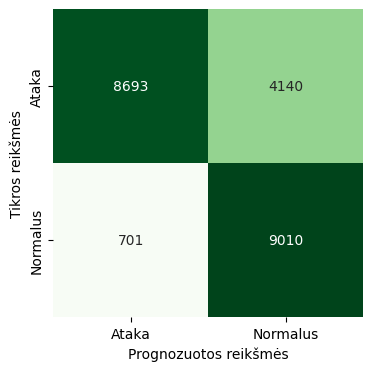

In [ ]:
plot_confusion_matrix(y_test, y_pred_svc)

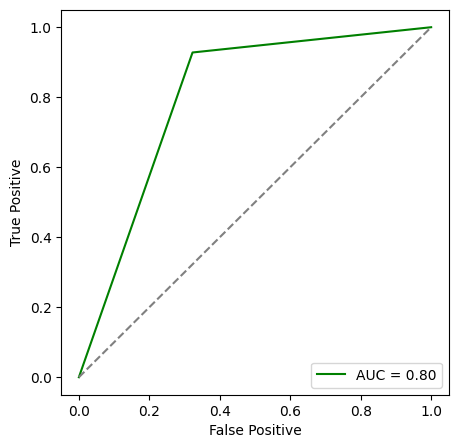

In [ ]:
plot_auc(y_test, y_pred_svc)

In [ ]:
print(classification_report(y_test, y_pred_svc, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.93      0.68      0.78     12833
    Normalus       0.69      0.93      0.79      9711

    accuracy                           0.79     22544
   macro avg       0.81      0.80      0.79     22544
weighted avg       0.82      0.79      0.78     22544



### Fine-tuning

*note:* Try out C=0.1

In [ ]:
from sklearn.svm import SVC

svc_model = SVC()

param_grid_svc = {
    'C': [1, 10, 100],
    'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid = GridSearchCV(SVC(),param_grid_svc,refit=True,verbose=2, cv=2)
grid.fit(X_train,y_train)
grid.best_estimator_

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  41.1s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=  27.4s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   8.4s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   7.2s
[CV] END .......................C=1, gamma=1, kernel=sigmoid; total time=11.2min
[CV] END .......................C=1, gamma=1, kernel=sigmoid; total time=10.1min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  29.6s
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time=  30.9s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=  21.2s
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time=  22.6s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time= 1.9min
[CV] END .....................C=1, gamma=0.1, ke

SVC(C=100, gamma=1)

In [ ]:
y_pred_svc_tuned = grid.predict(X_test)
calculate_results(y_test, y_pred_svc_tuned)

{'accuracy': 79.59102200141945,
 'precision': 0.8461325361917625,
 'recall': 0.7959102200141944,
 'f1': 0.7944483448630686}

In [ ]:
pickle.dump(grid, open(BASE+'models/original/SVC.sav', 'wb'))

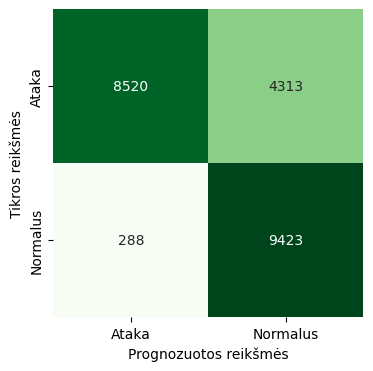

In [ ]:
plot_confusion_matrix(y_test, y_pred_svc_tuned)

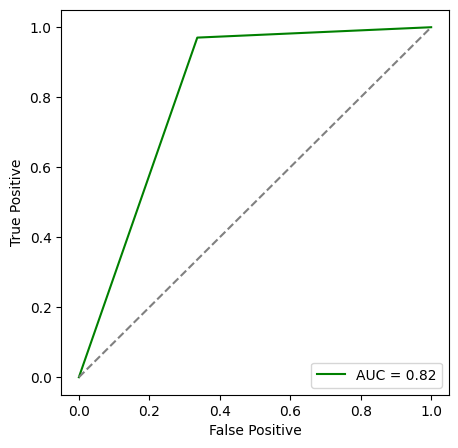

In [ ]:
plot_auc(y_test, y_pred_svc_tuned)

In [ ]:
print(classification_report(y_test, y_pred_svc_tuned, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.97      0.66      0.79     12833
    Normalus       0.69      0.97      0.80      9711

    accuracy                           0.80     22544
   macro avg       0.83      0.82      0.80     22544
weighted avg       0.85      0.80      0.79     22544



## KNN

### Base parameters

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

calculate_results(y_test, y_pred_knn)

{'accuracy': 76.86745919091554,
 'precision': 0.8123262142323451,
 'recall': 0.7686745919091554,
 'f1': 0.7674412215505494}

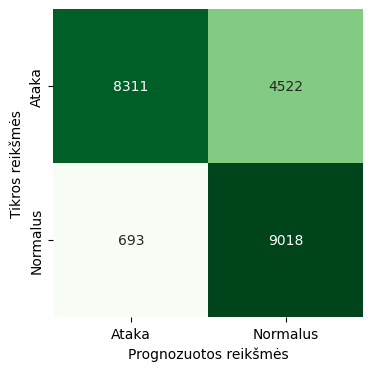

In [ ]:
plot_confusion_matrix(y_test, y_pred_knn)

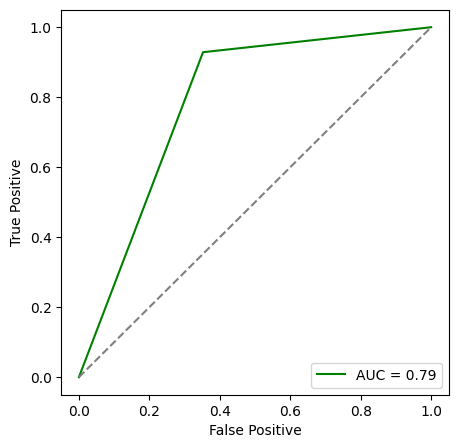

In [ ]:
plot_auc(y_test, y_pred_knn)

In [ ]:
print(classification_report(y_test, y_pred_knn, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.92      0.65      0.76     12833
    Normalus       0.67      0.93      0.78      9711

    accuracy                           0.77     22544
   macro avg       0.79      0.79      0.77     22544
weighted avg       0.81      0.77      0.77     22544



### Fine-tuning

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def objective_knn(trial):
  param = {
      'n_neighbors': trial.suggest_int("n_neighbors", 3, 10),
      'weights': trial.suggest_categorical("weights", ['uniform', 'distance']),
      'metric': trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
  }

  model = KNeighborsClassifier(**param)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective_knn, n_trials=48)

[I 2023-04-16 15:40:33,733] A new study created in memory with name: no-name-56eb3f9d-84cf-43c0-b624-86a95f7d0936
[I 2023-04-16 15:44:50,323] Trial 0 finished with value: 0.7767476933995742 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.7767476933995742.
[I 2023-04-16 15:48:36,603] Trial 1 finished with value: 0.7814939673527325 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.7814939673527325.
[I 2023-04-16 15:52:19,177] Trial 2 finished with value: 0.7786550745209369 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 1 with value: 0.7814939673527325.
[I 2023-04-16 15:52:41,113] Trial 3 finished with value: 0.7785663591199432 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 1 with value: 0.7814939673527325.
[I 2023-04-16 15:53:01,196] Trial 4 finished with value: 0.779

In [ ]:
study.best_params

{'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan'}

In [ ]:
knn_model_tuned = KNeighborsClassifier(**study.best_params)
knn_model_tuned.fit(X_train, y_train)

y_pred_knn_tuned = knn_model_tuned.predict(X_test)

calculate_results(y_test, y_pred_knn_tuned)

{'accuracy': 78.14939673527324,
 'precision': 0.8193030531094286,
 'recall': 0.7814939673527325,
 'f1': 0.7809116285780132}

In [ ]:
pickle.dump(knn_model_tuned, open(BASE+'models/original/KNN.sav', 'wb'))

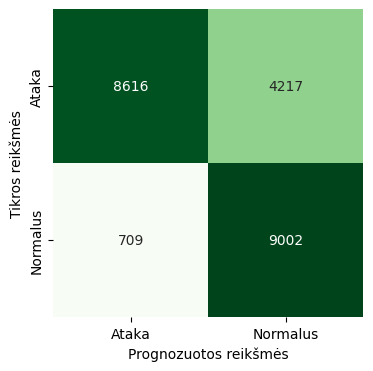

In [ ]:
plot_confusion_matrix(y_test, y_pred_knn_tuned)

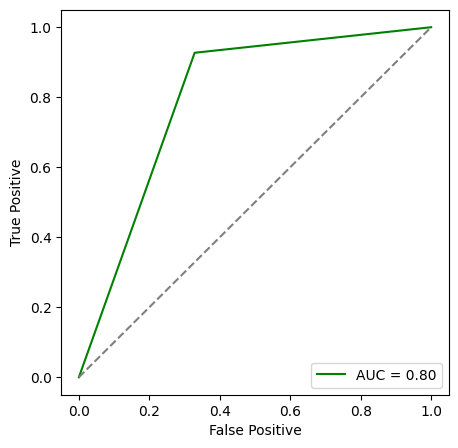

In [ ]:
plot_auc(y_test, y_pred_knn_tuned)

In [ ]:
print(classification_report(y_test, y_pred_knn_tuned, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.92      0.67      0.78     12833
    Normalus       0.68      0.93      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.80      0.80      0.78     22544
weighted avg       0.82      0.78      0.78     22544



## NB

### Base parameters

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)
calculate_results(y_test, y_pred_knn)

{'accuracy': 76.86745919091554,
 'precision': 0.8123262142323451,
 'recall': 0.7686745919091554,
 'f1': 0.7674412215505494}

In [ ]:
pickle.dump(nb_model, open(BASE+'models/original/NB.sav', 'wb'))

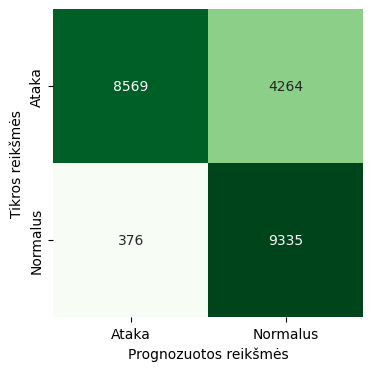

In [ ]:
plot_confusion_matrix(y_test, y_pred_nb)

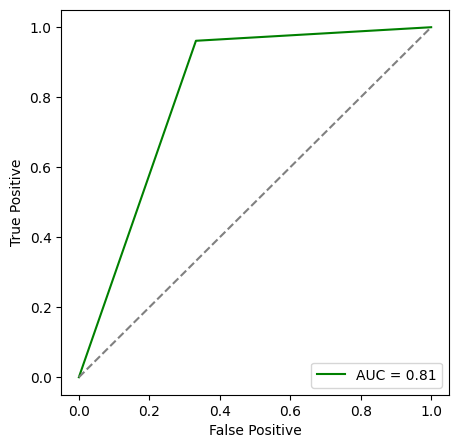

In [ ]:
plot_auc(y_test, y_pred_nb)

In [ ]:
print(classification_report(y_test, y_pred_nb, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.96      0.67      0.79     12833
    Normalus       0.69      0.96      0.80      9711

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544



## Decision Tree

### Base parameters

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
calculate_results(y_test, y_pred_dt)

{'accuracy': 79.57327892122072,
 'precision': 0.8413576070920044,
 'recall': 0.7957327892122072,
 'f1': 0.7946400290396024}

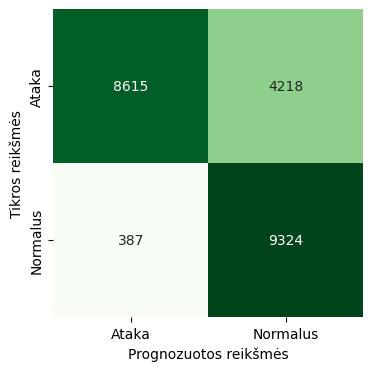

In [ ]:
plot_confusion_matrix(y_test, y_pred_dt)

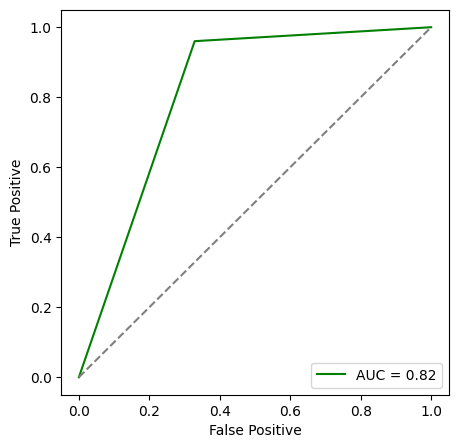

In [ ]:
plot_auc(y_test, y_pred_dt)

In [ ]:
print(classification_report(y_test, y_pred_dt, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.96      0.67      0.79     12833
    Normalus       0.69      0.96      0.80      9711

    accuracy                           0.80     22544
   macro avg       0.82      0.82      0.80     22544
weighted avg       0.84      0.80      0.79     22544



### Fine-tuning

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def objective_dt(trial):
  param = {
      'max_depth': trial.suggest_int("max_depth", 5, X_train.shape[1]),
      'min_samples_split': trial.suggest_int("min_samples_split", 2, 20),
      'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 20),
  }

  model = DecisionTreeClassifier(**param)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective_dt, n_trials=100)

[I 2023-04-17 07:34:00,019] A new study created in memory with name: no-name-815c5afa-b266-4150-aadb-423a5e760ea0
[I 2023-04-17 07:34:03,439] Trial 0 finished with value: 0.7810503903477644 and parameters: {'max_depth': 36, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.7810503903477644.
[I 2023-04-17 07:34:05,164] Trial 1 finished with value: 0.7747515968772178 and parameters: {'max_depth': 21, 'min_samples_split': 6, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.7810503903477644.
[I 2023-04-17 07:34:06,748] Trial 2 finished with value: 0.7769694819020582 and parameters: {'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.7810503903477644.
[I 2023-04-17 07:34:07,896] Trial 3 finished with value: 0.8117459190915542 and parameters: {'max_depth': 44, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.8117459190915542.
[I 2023-04-17 07:34:08,872] Trial 4 finished with value: 0.7

In [ ]:
study.best_params

{'max_depth': 52, 'min_samples_split': 18, 'min_samples_leaf': 2}

In [ ]:
dt_model_tuned = DecisionTreeClassifier(**study.best_params)
dt_model_tuned.fit(X_train, y_train)

y_pred_dt_tuned = dt_model_tuned.predict(X_test)

calculate_results(y_test, y_pred_dt_tuned)

{'accuracy': 81.3875088715401,
 'precision': 0.8364644592889979,
 'recall': 0.813875088715401,
 'f1': 0.8143844955217696}

In [ ]:
pickle.dump(dt_model_tuned, open(BASE+'models/original/DT.sav', 'wb'))

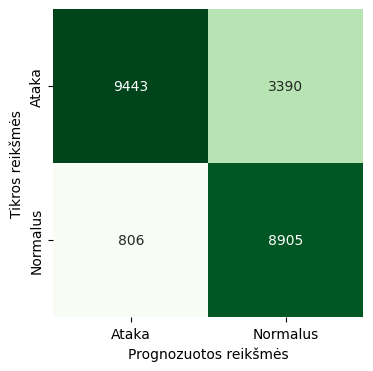

In [ ]:
plot_confusion_matrix(y_test, y_pred_dt_tuned)

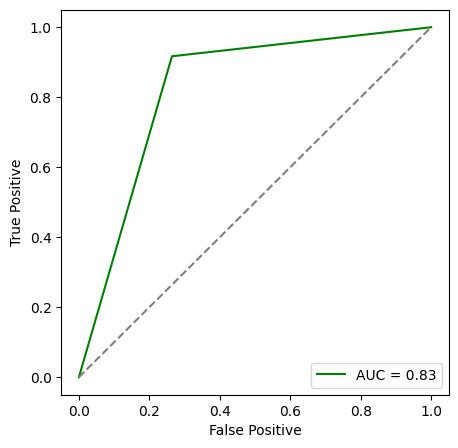

In [ ]:
plot_auc(y_test, y_pred_dt_tuned)

In [ ]:
print(classification_report(y_test, y_pred_dt_tuned, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.92      0.74      0.82     12833
    Normalus       0.72      0.92      0.81      9711

    accuracy                           0.81     22544
   macro avg       0.82      0.83      0.81     22544
weighted avg       0.84      0.81      0.81     22544



## Random Forest

### Base parameters

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
calculate_results(y_test, y_pred_rf)

{'accuracy': 78.63289567068843,
 'precision': 0.8418066112816456,
 'recall': 0.7863289567068843,
 'f1': 0.7842650076967361}

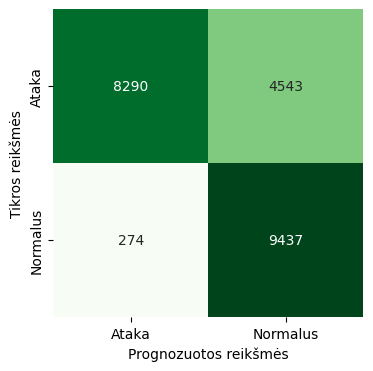

In [ ]:
plot_confusion_matrix(y_test, y_pred_rf)

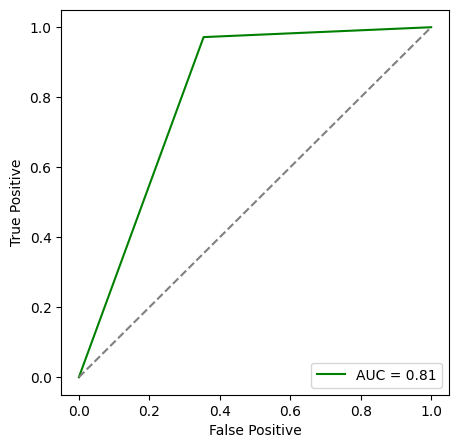

In [ ]:
plot_auc(y_test, y_pred_rf)

In [ ]:
print(classification_report(y_test, y_pred_rf, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.97      0.65      0.77     12833
    Normalus       0.68      0.97      0.80      9711

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.78     22544



### Fine-tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def objective_rf(trial):
  param = {
      'n_estimators': trial.suggest_int('n_estimators', 5, 500),
      'max_depth': trial.suggest_int('max_depth', 4, 50),
      'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 60),
  }

  model = RandomForestClassifier(**param)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=100)

[I 2023-04-17 07:44:32,604] A new study created in memory with name: no-name-e870875a-fcab-4412-8388-78a85642081f
[I 2023-04-17 07:44:35,007] Trial 0 finished with value: 0.785707948899929 and parameters: {'n_estimators': 10, 'max_depth': 18, 'min_samples_split': 129, 'min_samples_leaf': 13}. Best is trial 0 with value: 0.785707948899929.
[I 2023-04-17 07:45:12,182] Trial 1 finished with value: 0.7646823988644429 and parameters: {'n_estimators': 280, 'max_depth': 29, 'min_samples_split': 117, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.785707948899929.
[I 2023-04-17 07:45:29,555] Trial 2 finished with value: 0.7643718949609652 and parameters: {'n_estimators': 141, 'max_depth': 41, 'min_samples_split': 141, 'min_samples_leaf': 43}. Best is trial 0 with value: 0.785707948899929.
[I 2023-04-17 07:45:39,063] Trial 3 finished with value: 0.7814052519517388 and parameters: {'n_estimators': 85, 'max_depth': 41, 'min_samples_split': 68, 'min_samples_leaf': 45}. Best is trial 0 with 

In [ ]:
rf_model_tuned = RandomForestClassifier(**study.best_params)
rf_model_tuned.fit(X_train, y_train)
y_pred_rf_tuned = rf_model_tuned.predict(X_test)

In [ ]:
pickle.dump(rf_model_tuned, open(BASE+'models/original/RF.sav', 'wb'))

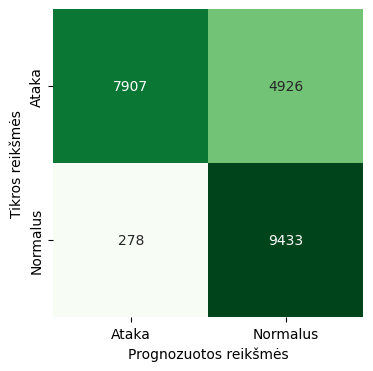

In [ ]:
plot_confusion_matrix(y_test, y_pred_rf_tuned)

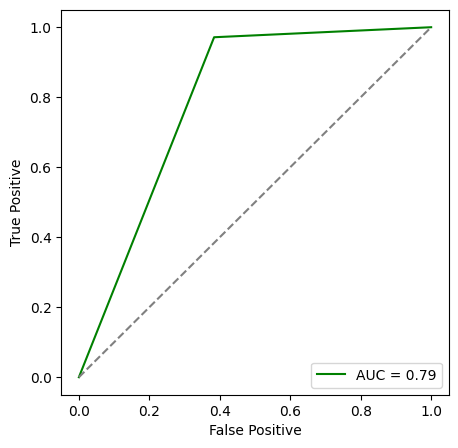

In [ ]:
plot_auc(y_test, y_pred_rf_tuned)

In [ ]:
print(classification_report(y_test, y_pred_rf_tuned, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.97      0.62      0.75     12833
    Normalus       0.66      0.97      0.78      9711

    accuracy                           0.77     22544
   macro avg       0.81      0.79      0.77     22544
weighted avg       0.83      0.77      0.77     22544



## XGBoost Classifier

### Base parameters

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
calculate_results(y_test, y_pred_xgb)

{'accuracy': 78.72161107168203,
 'precision': 0.8417550378846486,
 'recall': 0.7872161107168204,
 'f1': 0.7852513460805232}

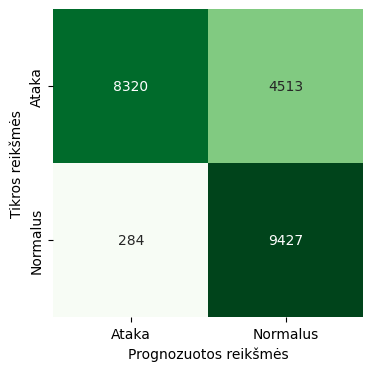

In [ ]:
plot_confusion_matrix(y_test, y_pred_xgb)

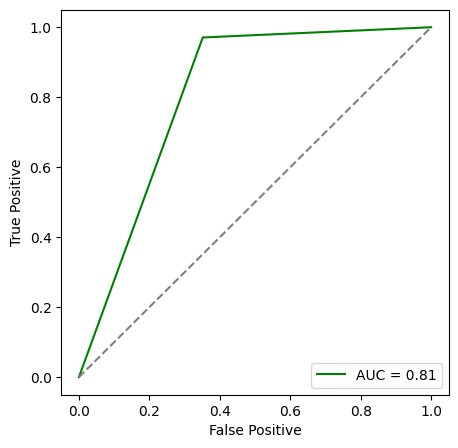

In [ ]:
plot_auc(y_test, y_pred_xgb)

In [ ]:
print(classification_report(y_test, y_pred_xgb, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.97      0.65      0.78     12833
    Normalus       0.68      0.97      0.80      9711

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.84      0.79      0.79     22544



### Fine-tuning

In [ ]:
from xgboost import XGBClassifier

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
study.best_params

[I 2023-04-17 08:08:20,279] A new study created in memory with name: no-name-ce38459a-77b6-4470-bf0a-1e25b2224671
[I 2023-04-17 08:10:06,415] Trial 0 finished with value: 0.781582682753726 and parameters: {'max_depth': 35, 'learning_rate': 0.4681964657237892, 'n_estimators': 734, 'min_child_weight': 8, 'gamma': 0.9303562139507887, 'subsample': 0.2474353279111797, 'colsample_bytree': 0.565582629284811, 'reg_alpha': 0.43158030599640834, 'reg_lambda': 0.336677936031824, 'random_state': 935}. Best is trial 0 with value: 0.781582682753726.
[I 2023-04-17 08:11:47,131] Trial 1 finished with value: 0.7852200141944642 and parameters: {'max_depth': 61, 'learning_rate': 0.8263528416528145, 'n_estimators': 406, 'min_child_weight': 10, 'gamma': 0.5146187725259324, 'subsample': 0.8993130862071979, 'colsample_bytree': 0.5801436966778227, 'reg_alpha': 0.8391819007242881, 'reg_lambda': 0.028662315519851385, 'random_state': 468}. Best is trial 1 with value: 0.7852200141944642.
[I 2023-04-17 08:17:04,750

{'max_depth': 85,
 'learning_rate': 0.3703781969819103,
 'n_estimators': 52,
 'min_child_weight': 9,
 'gamma': 0.964269984594394,
 'subsample': 0.43873539218623236,
 'colsample_bytree': 0.8650573946055883,
 'reg_alpha': 0.04487847350600713,
 'reg_lambda': 0.6438339960309731,
 'random_state': 761}

In [ ]:
xgb_model_tuned = XGBClassifier(**study.best_params)
xgb_model_tuned.fit(X_train, y_train)
y_pred_xgb_tuned = xgb_model_tuned.predict(X_test)
calculate_results(y_test, y_pred_xgb_tuned)

{'accuracy': 81.06369765791341,
 'precision': 0.854628031546957,
 'recall': 0.8106369765791341,
 'f1': 0.809815590507536}

In [ ]:
pickle.dump(xgb_model_tuned, open(BASE+'models/original/XGB.sav', 'wb'))

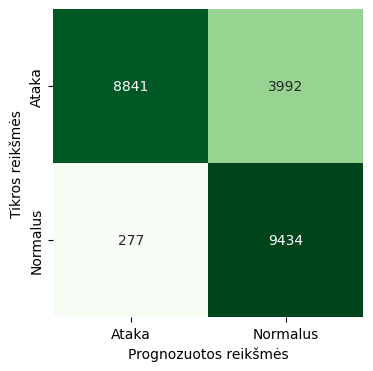

In [ ]:
plot_confusion_matrix(y_test, y_pred_xgb_tuned)

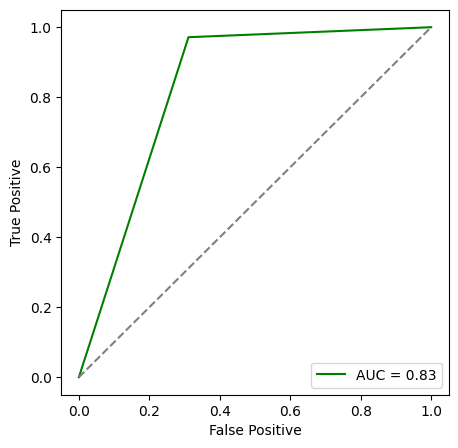

In [ ]:
plot_auc(y_test, y_pred_xgb_tuned)

In [ ]:
print(classification_report(y_test, y_pred_xgb_tuned, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.97      0.69      0.81     12833
    Normalus       0.70      0.97      0.82      9711

    accuracy                           0.81     22544
   macro avg       0.84      0.83      0.81     22544
weighted avg       0.85      0.81      0.81     22544



## TensorFlow Decision Forest

In [ ]:
!pip install tensorflow tensorflow_decision_forests

### Base parameters

In [ ]:
import tensorflow_decision_forests as tfdf

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="attack")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="attack")

tfdf_model = tfdf.keras.RandomForestModel()
tfdf_model.fit(train_ds)


Use /tmp/tmp3ri_dkfw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:08.989404. Found 125973 examples.
Training model...
Model trained in 0:01:34.360363
Compiling model...
Model compiled.


In [ ]:
tfdf_model.save(BASE+'models/original/tfdf_model')

In [ ]:
y_pred_tdfd = tfdf_model.predict(test_ds)

23/23 [==============================] - 2s 92ms/step


In [ ]:
y_pred_tfdf_round = np.round(y_pred_tdfd)

In [ ]:
calculate_results(y_test, y_pred_tfdf_round)

{'accuracy': 78.35344215755855,
 'precision': 0.8399514456790795,
 'recall': 0.7835344215755855,
 'f1': 0.781333357912492}

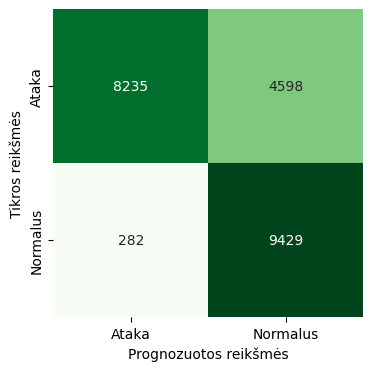

In [ ]:
plot_confusion_matrix(y_test, y_pred_tfdf_round)

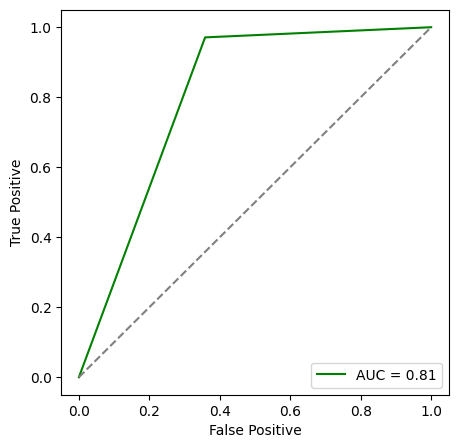

In [ ]:
plot_auc(y_test, y_pred_tfdf_round)

## Neural Networks

In [ ]:
import tensorflow as tf

In [ ]:
X_train_lstm = np.reshape(X_train.to_numpy(), (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test.to_numpy(), (X_test.shape[0], 1, X_test.shape[1]))

### LSTM

In [ ]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(1, X_train_lstm.shape[2])),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=100,
                              batch_size=32, validation_split=.2)

Epoch 1/100
3150/3150 [==============================] - 53s 15ms/step - loss: 0.0631 - accuracy: 0.9793 - val_loss: 0.0239 - val_accuracy: 0.9926
Epoch 2/100
3150/3150 [==============================] - 27s 9ms/step - loss: 0.0259 - accuracy: 0.9919 - val_loss: 0.0211 - val_accuracy: 0.9943
Epoch 3/100
3150/3150 [==============================] - 27s 9ms/step - loss: 0.0213 - accuracy: 0.9936 - val_loss: 0.0153 - val_accuracy: 0.9960
Epoch 4/100
3150/3150 [==============================] - 29s 9ms/step - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.0143 - val_accuracy: 0.9960
Epoch 5/100
3150/3150 [==============================] - 27s 9ms/step - loss: 0.0169 - accuracy: 0.9948 - val_loss: 0.0139 - val_accuracy: 0.9960
Epoch 6/100
3150/3150 [==============================] - 27s 9ms/step - loss: 0.0159 - accuracy: 0.9950 - val_loss: 0.0127 - val_accuracy: 0.9967
Epoch 7/100
3150/3150 [==============================] - 28s 9ms/step - loss: 0.0146 - accuracy: 0.9954 - val_loss: 0.0146 

In [ ]:
lstm_model.save(BASE+'models/original/lstm.h5')

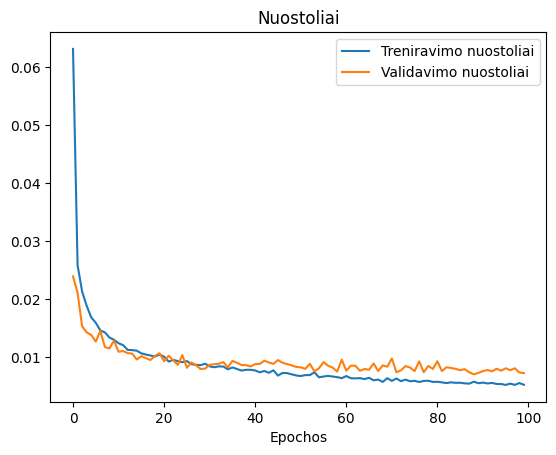

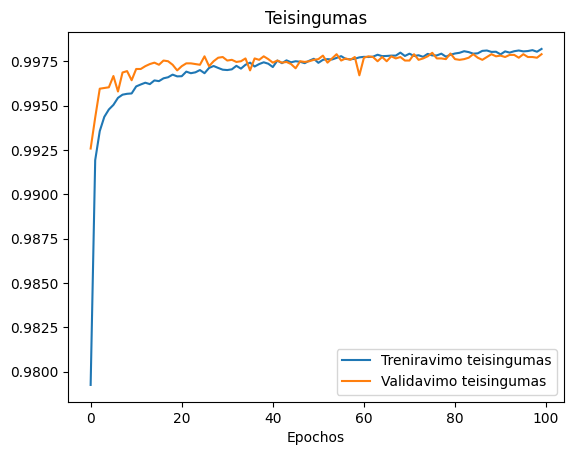

In [ ]:
plot_loss_curves(lstm_history)

In [ ]:
y_pred_lstm = lstm_model.predict(X_test_lstm, verbose=0)
calculate_results(y_test, tf.round(y_pred_lstm))

{'accuracy': 78.4332860184528,
 'precision': 0.8192395894113701,
 'recall': 0.7843328601845281,
 'f1': 0.7840056708942715}

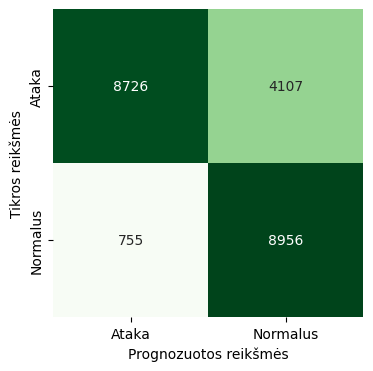

In [ ]:
plot_confusion_matrix(y_test, tf.round(y_pred_lstm))

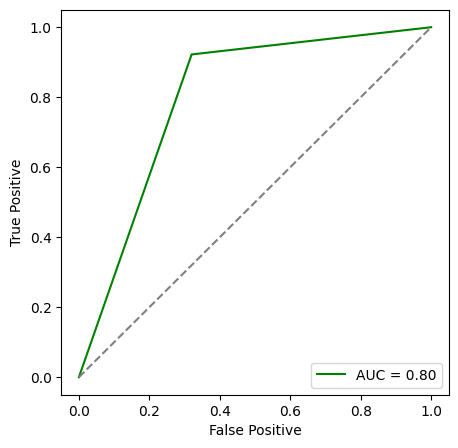

In [ ]:
plot_auc(y_test, tf.round(y_pred_lstm))

In [ ]:
print(classification_report(y_test, tf.round(y_pred_lstm),
                            target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.92      0.68      0.78     12833
    Normalus       0.69      0.92      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.80      0.80      0.78     22544
weighted avg       0.82      0.78      0.78     22544



### RNN

In [ ]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=True, input_shape=(1, X_train_lstm.shape[2])),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn_history = rnn_model.fit(X_train_lstm, y_train, epochs=100, batch_size=32,
                            validation_split=.2)

Epoch 1/100
3150/3150 [==============================] - 23s 6ms/step - loss: 0.0474 - accuracy: 0.9825 - val_loss: 0.0279 - val_accuracy: 0.9906
Epoch 2/100
3150/3150 [==============================] - 17s 5ms/step - loss: 0.0284 - accuracy: 0.9902 - val_loss: 0.0219 - val_accuracy: 0.9923
Epoch 3/100
3150/3150 [==============================] - 17s 6ms/step - loss: 0.0249 - accuracy: 0.9913 - val_loss: 0.0224 - val_accuracy: 0.9923
Epoch 4/100
3150/3150 [==============================] - 16s 5ms/step - loss: 0.0230 - accuracy: 0.9922 - val_loss: 0.0208 - val_accuracy: 0.9928
Epoch 5/100
3150/3150 [==============================] - 17s 5ms/step - loss: 0.0216 - accuracy: 0.9930 - val_loss: 0.0161 - val_accuracy: 0.9957
Epoch 6/100
3150/3150 [==============================] - 17s 5ms/step - loss: 0.0191 - accuracy: 0.9943 - val_loss: 0.0144 - val_accuracy: 0.9964
Epoch 7/100
3150/3150 [==============================] - 16s 5ms/step - loss: 0.0167 - accuracy: 0.9950 - val_loss: 0.0134 -

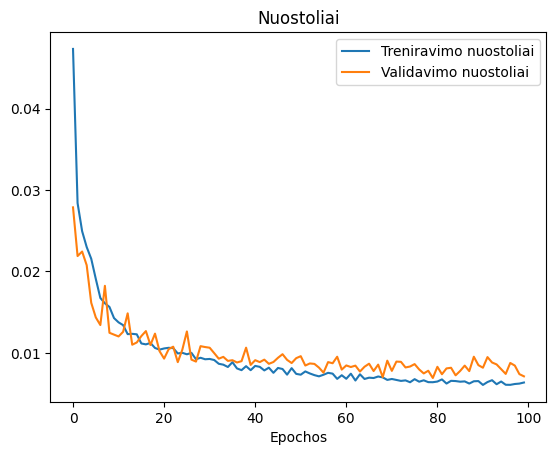

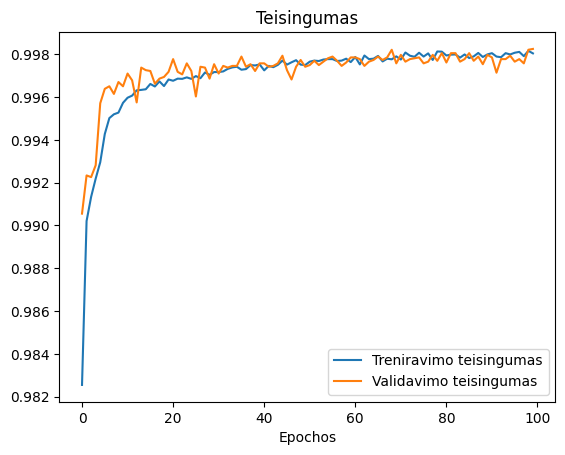

In [ ]:
plot_loss_curves(rnn_history)

In [ ]:
y_pred_rnn = rnn_model.predict(X_test_lstm, verbose=0)
calculate_results(y_test, tf.round(y_pred_rnn))

{'accuracy': 78.0207594038325,
 'precision': 0.8162361252311074,
 'recall': 0.7802075940383251,
 'f1': 0.7797651570822893}

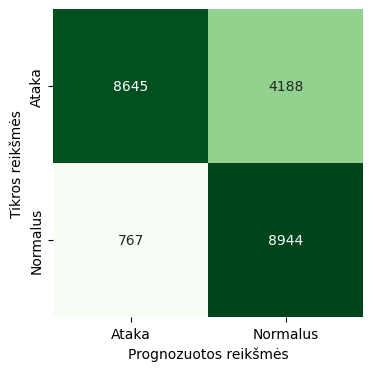

In [ ]:
plot_confusion_matrix(y_test, tf.round(y_pred_rnn))

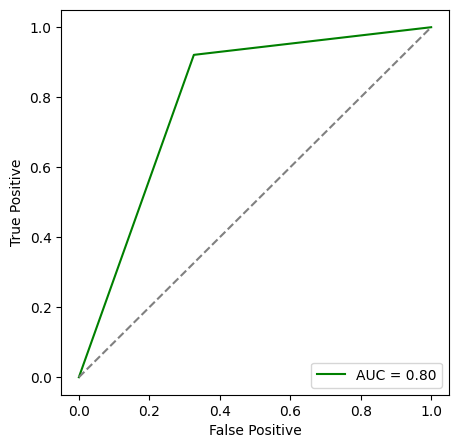

In [ ]:
plot_auc(y_test, tf.round(y_pred_rnn))

In [ ]:
print(classification_report(y_test, tf.round(y_pred_rnn),
                            target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.92      0.67      0.78     12833
    Normalus       0.68      0.92      0.78      9711

    accuracy                           0.78     22544
   macro avg       0.80      0.80      0.78     22544
weighted avg       0.82      0.78      0.78     22544



In [ ]:
rnn_model.save(BASE+'models/original/rnn.h5')

### MLP

In [ ]:
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, input_dim=X_train.shape[1], activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

mlp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mlp_history = mlp_model.fit(X_train, y_train, epochs=100, batch_size=32, 
                            validation_split=.2)

Epoch 1/100
3150/3150 [==============================] - 16s 4ms/step - loss: 0.0500 - accuracy: 0.9831 - val_loss: 0.0213 - val_accuracy: 0.9947
Epoch 2/100
3150/3150 [==============================] - 9s 3ms/step - loss: 0.0196 - accuracy: 0.9944 - val_loss: 0.0154 - val_accuracy: 0.9961
Epoch 3/100
3150/3150 [==============================] - 7s 2ms/step - loss: 0.0155 - accuracy: 0.9953 - val_loss: 0.0145 - val_accuracy: 0.9962
Epoch 4/100
3150/3150 [==============================] - 8s 3ms/step - loss: 0.0130 - accuracy: 0.9960 - val_loss: 0.0119 - val_accuracy: 0.9967
Epoch 5/100
3150/3150 [==============================] - 9s 3ms/step - loss: 0.0118 - accuracy: 0.9962 - val_loss: 0.0112 - val_accuracy: 0.9969
Epoch 6/100
3150/3150 [==============================] - 7s 2ms/step - loss: 0.0107 - accuracy: 0.9967 - val_loss: 0.0114 - val_accuracy: 0.9970
Epoch 7/100
3150/3150 [==============================] - 8s 3ms/step - loss: 0.0099 - accuracy: 0.9968 - val_loss: 0.0116 - val_a

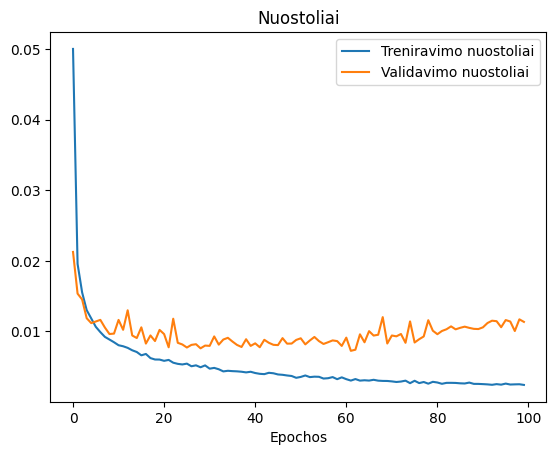

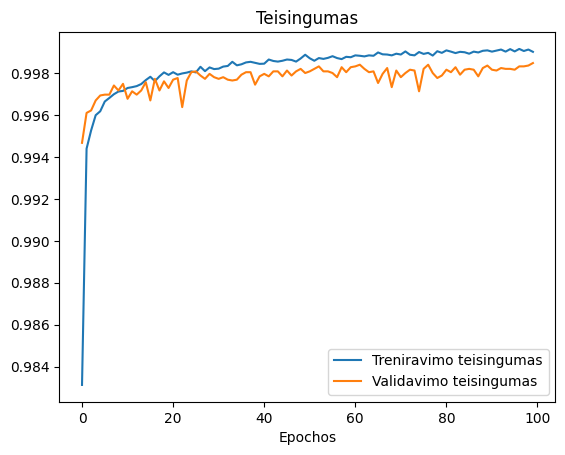

In [ ]:
plot_loss_curves(mlp_history)

In [ ]:
y_pred_mlp = mlp_model.predict(X_test, verbose=0)
calculate_results(y_test, tf.round(y_pred_mlp))

{'accuracy': 78.18044712562101,
 'precision': 0.8295624454504794,
 'recall': 0.7818044712562101,
 'f1': 0.7803591583590173}

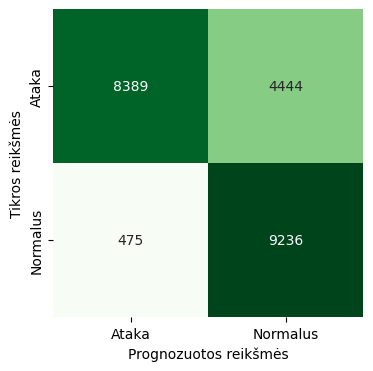

In [ ]:
plot_confusion_matrix(y_test, tf.round(y_pred_mlp))

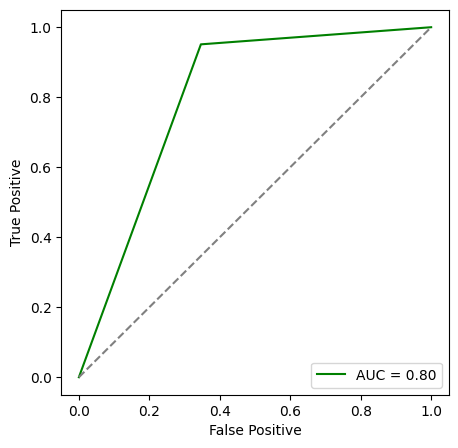

In [ ]:
plot_auc(y_test, tf.round(y_pred_mlp))

In [ ]:
print(classification_report(y_test, tf.round(y_pred_mlp),
                            target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.95      0.65      0.77     12833
    Normalus       0.68      0.95      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.81      0.80      0.78     22544
weighted avg       0.83      0.78      0.78     22544



In [ ]:
mlp_model.save(BASE+'models/original/mlp.h5')

### 1D-CNN

In [ ]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=X_train.shape[1], padding='same',
                           activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPool1D(5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train, y_train, epochs=100, batch_size=32,
                            validation_split=.2)

Epoch 1/100
3150/3150 [==============================] - 36s 11ms/step - loss: 0.0302 - accuracy: 0.9898 - val_loss: 0.0185 - val_accuracy: 0.9933
Epoch 2/100
3150/3150 [==============================] - 29s 9ms/step - loss: 0.0179 - accuracy: 0.9944 - val_loss: 0.0131 - val_accuracy: 0.9958
Epoch 3/100
3150/3150 [==============================] - 29s 9ms/step - loss: 0.0153 - accuracy: 0.9949 - val_loss: 0.0124 - val_accuracy: 0.9963
Epoch 4/100
3150/3150 [==============================] - 29s 9ms/step - loss: 0.0134 - accuracy: 0.9956 - val_loss: 0.0167 - val_accuracy: 0.9943
Epoch 5/100
3150/3150 [==============================] - 31s 10ms/step - loss: 0.0128 - accuracy: 0.9956 - val_loss: 0.0111 - val_accuracy: 0.9968
Epoch 6/100
3150/3150 [==============================] - 30s 9ms/step - loss: 0.0116 - accuracy: 0.9964 - val_loss: 0.0103 - val_accuracy: 0.9971
Epoch 7/100
3150/3150 [==============================] - 30s 9ms/step - loss: 0.0108 - accuracy: 0.9964 - val_loss: 0.0103

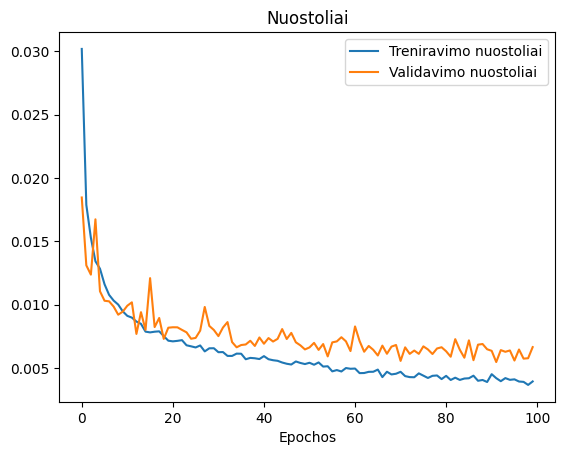

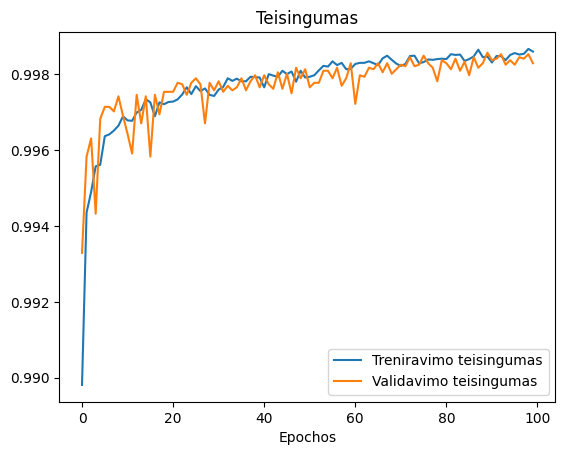

In [ ]:
plot_loss_curves(cnn_history)

In [ ]:
y_pred_cnn = cnn_model.predict(X_test, verbose=0)
calculate_results(y_test, tf.round(y_pred_cnn))

{'accuracy': 79.59989354151881,
 'precision': 0.8261374492543564,
 'recall': 0.7959989354151881,
 'f1': 0.7960666449036384}

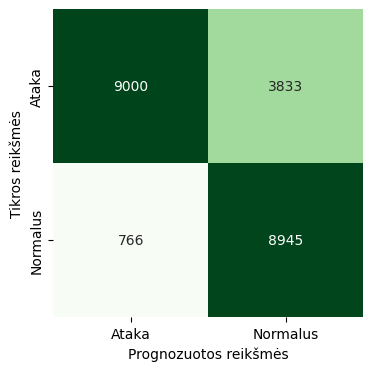

In [ ]:
plot_confusion_matrix(y_test, tf.round(y_pred_cnn))

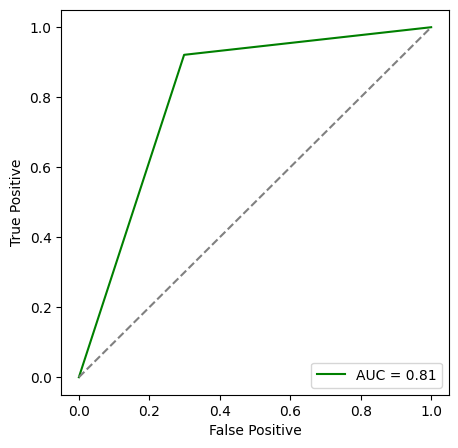

In [ ]:
plot_auc(y_test, tf.round(y_pred_cnn))

In [ ]:
print(classification_report(y_test, tf.round(y_pred_cnn),
                            target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.92      0.70      0.80     12833
    Normalus       0.70      0.92      0.80      9711

    accuracy                           0.80     22544
   macro avg       0.81      0.81      0.80     22544
weighted avg       0.83      0.80      0.80     22544



In [ ]:
cnn_model.save(BASE+'models/original/cnn.h5')

# Dimensionality Reduction and Feature Selection

In [ ]:
import pickle

## Dimensionality Reduction

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 0.99, random_state=40).fit(X_train)

X_train_dr = pca.transform(X_train)
X_test_dr = pca.transform(X_test)

In [ ]:
output_pca = open(BASE+'Helpers/pca.pkl', 'wb')
pickle.dump(pca, output_pca)
output_pca.close()

## Feature selection

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
model = DecisionTreeClassifier()
rfe = RFECV(model, n_jobs=-1)
rfe.fit(X_train_dr, y_train)

RFECV(estimator=DecisionTreeClassifier(), n_jobs=-1)

In [ ]:
X_train_fs = rfe.transform(X_train_dr)
X_test_fs = rfe.transform(X_test_dr)

In [ ]:
pd.DataFrame(X_train_fs).to_csv(BASE+'Train_Features.csv', index=False)
pd.DataFrame(X_test_fs).to_csv(BASE+'Test_Features.csv', index=False)

In [ ]:
output_fs = open(BASE+'Helpers/rfe.pkl', 'wb')
pickle.dump(rfe, output_fs)
output_fs.close()

# Modeling Experimentations After Feature Selection

## SVC

### Base parameters

In [ ]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train_fs, y_train)
y_pred_svc = svc_model.predict(X_test_fs)
calculate_results(y_test, y_pred_svc)

{'accuracy': 78.388928317956,
 'precision': 0.821390602706336,
 'recall': 0.78388928317956,
 'f1': 0.7833495782882962}

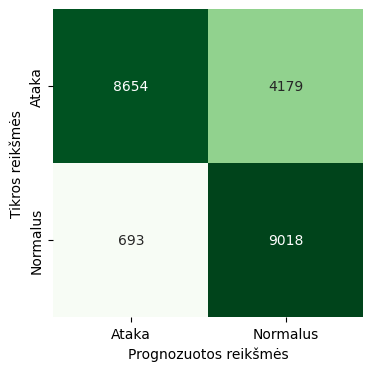

In [ ]:
plot_confusion_matrix(y_test, y_pred_svc)

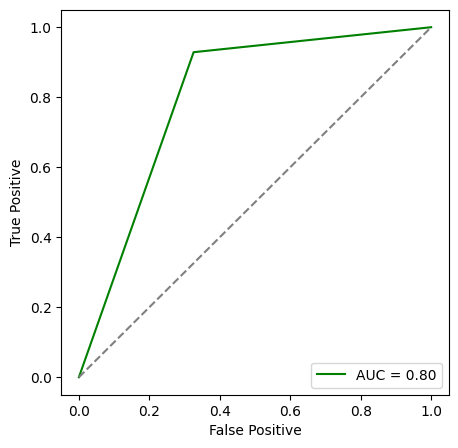

In [ ]:
plot_auc(y_test, y_pred_svc)

In [ ]:
print(classification_report(y_test, y_pred_svc, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.93      0.67      0.78     12833
    Normalus       0.68      0.93      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.80      0.80      0.78     22544
weighted avg       0.82      0.78      0.78     22544



### Fine-tuning

In [ ]:
from sklearn.svm import SVC

def objective_svc(trial):
  param = {
      'C': trial.suggest_float("C",0.1,3.0,log=True),
      'gamma': trial.suggest_categorical("gamma", ['auto', 'scale']),
      'degree': trial.suggest_int("degree",1,3,log=True)
  }

  model = SVC(**param)
  model.fit(X_train_fs, y_train)
  y_pred = model.predict(X_test_fs)
  return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective_svc, n_trials=50)

[I 2023-04-18 07:32:08,586] A new study created in memory with name: no-name-052b1fdb-188f-40ec-87ac-24b6872f52bf
[I 2023-04-18 07:33:57,744] Trial 0 finished with value: 0.7811834634492548 and parameters: {'C': 0.43715456034292044, 'gamma': 'scale', 'degree': 2}. Best is trial 0 with value: 0.7811834634492548.
[I 2023-04-18 07:40:36,671] Trial 1 finished with value: 0.7497338537970192 and parameters: {'C': 0.38563538522538376, 'gamma': 'auto', 'degree': 2}. Best is trial 0 with value: 0.7811834634492548.
[I 2023-04-18 07:41:40,174] Trial 2 finished with value: 0.7839336408800568 and parameters: {'C': 0.9095295091044576, 'gamma': 'scale', 'degree': 3}. Best is trial 2 with value: 0.7839336408800568.
[I 2023-04-18 07:51:10,941] Trial 3 finished with value: 0.7483587650816181 and parameters: {'C': 0.324369544833059, 'gamma': 'auto', 'degree': 1}. Best is trial 2 with value: 0.7839336408800568.
[I 2023-04-18 07:56:07,106] Trial 4 finished with value: 0.7225425833924769 and parameters: {'C

In [ ]:
study.best_params

{'C': 1.634328994707368, 'gamma': 'scale', 'degree': 1}

In [ ]:
model_svc = SVC(**study.best_params)
model_svc.fit(X_train_fs, y_train)

y_pred_svc = model_svc.predict(X_test_fs)
calculate_results(y_test, y_pred_svc)

{'accuracy': 78.54418026969482,
 'precision': 0.8223703865211869,
 'recall': 0.7854418026969482,
 'f1': 0.78495918708747}

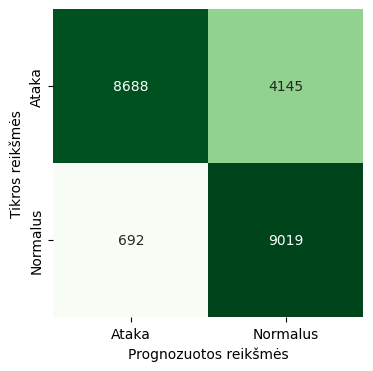

In [ ]:
plot_confusion_matrix(y_test, y_pred_svc)

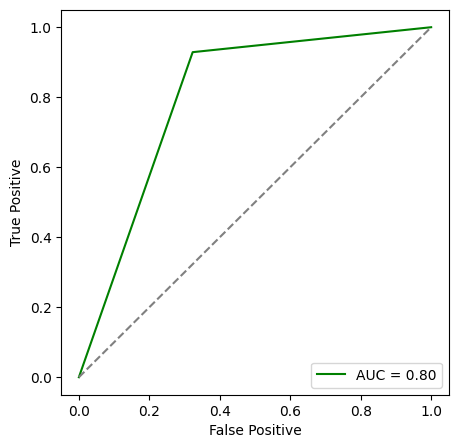

In [ ]:
plot_auc(y_test, y_pred_svc)

In [ ]:
print(classification_report(y_test, y_pred_svc, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.93      0.68      0.78     12833
    Normalus       0.69      0.93      0.79      9711

    accuracy                           0.79     22544
   macro avg       0.81      0.80      0.79     22544
weighted avg       0.82      0.79      0.78     22544



In [ ]:
pickle.dump(model_svc, open(BASE+'models/feature_selected/SVC.sav', 'wb'))

## KNN


### Base parameters

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_fs, y_train)

y_pred_knn = knn_model.predict(X_test_fs)

calculate_results(y_test, y_pred_knn)

{'accuracy': 77.05819730305181,
 'precision': 0.8135762367795119,
 'recall': 0.7705819730305181,
 'f1': 0.7694341036163856}

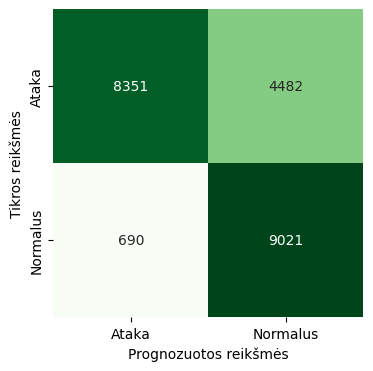

In [ ]:
plot_confusion_matrix(y_test, y_pred_knn)

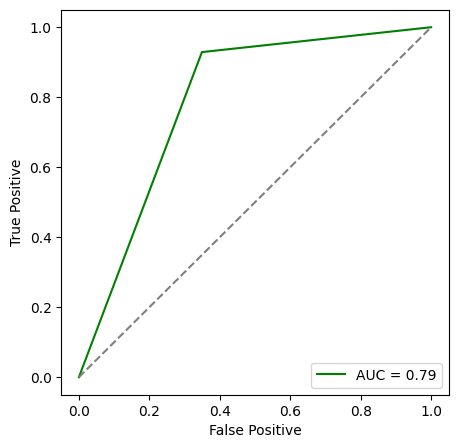

In [ ]:
plot_auc(y_test, y_pred_knn)

In [ ]:
print(classification_report(y_test, y_pred_knn, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.92      0.65      0.76     12833
    Normalus       0.67      0.93      0.78      9711

    accuracy                           0.77     22544
   macro avg       0.80      0.79      0.77     22544
weighted avg       0.81      0.77      0.77     22544



### Fine-tuning

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
def objective_knn(trial):
  param = {
      'n_neighbors': trial.suggest_int("n_neighbors", 3, 30),
      'weights': trial.suggest_categorical("weights", ['uniform', 'distance']),
      'metric': trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
  }

  model = KNeighborsClassifier(**param)
  model.fit(X_train_fs, y_train)
  y_pred = model.predict(X_test_fs)
  return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective_knn, n_trials=50)

[I 2023-04-18 09:04:06,507] A new study created in memory with name: no-name-4fe84d29-1377-4d39-91c5-bc258dc3c031
[I 2023-04-18 09:04:22,675] Trial 0 finished with value: 0.7751508161816891 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: 0.7751508161816891.
[I 2023-04-18 09:04:39,244] Trial 1 finished with value: 0.7722675656493967 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.7751508161816891.
[I 2023-04-18 09:04:55,773] Trial 2 finished with value: 0.7741749467707594 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.7751508161816891.
[I 2023-04-18 09:05:12,562] Trial 3 finished with value: 0.7734652235628106 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 0 with value: 0.7751508161816891.
[I 2023-04-18 09:05:30,247] Trial 4 finished with value: 0.772

In [ ]:
study.best_params

{'n_neighbors': 4, 'weights': 'uniform', 'metric': 'manhattan'}

In [ ]:
model_knn = KNeighborsClassifier(**study.best_params)
model_knn.fit(X_train_fs, y_train)

y_pred_knn = model_knn.predict(X_test_fs)
calculate_results(y_test, y_pred_knn)

{'accuracy': 78.29134137686302,
 'precision': 0.8201629006227263,
 'recall': 0.7829134137686302,
 'f1': 0.7823876856985964}

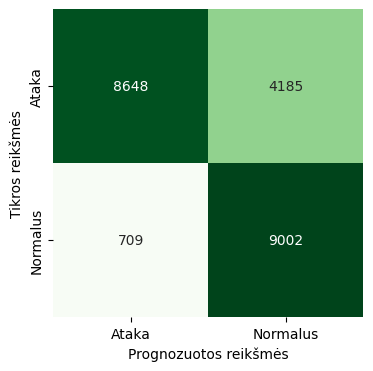

In [ ]:
plot_confusion_matrix(y_test, y_pred_knn)

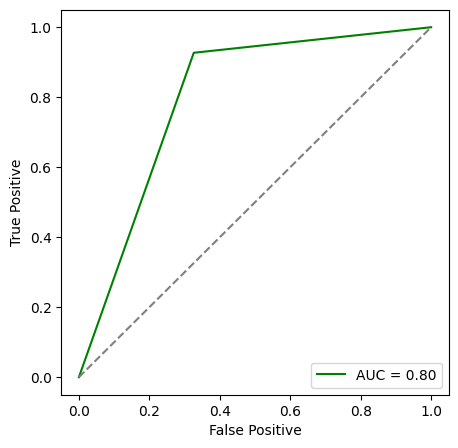

In [ ]:
plot_auc(y_test, y_pred_knn)

In [ ]:
print(classification_report(y_test, y_pred_knn, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.92      0.67      0.78     12833
    Normalus       0.68      0.93      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.80      0.80      0.78     22544
weighted avg       0.82      0.78      0.78     22544



In [ ]:
pickle.dump(model_knn, open(BASE+'models/feature_selected/KNN.sav', 'wb'))

## NB

### Base parameters

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train_fs, y_train)

y_pred_nb = nb_model.predict(X_test_fs)
calculate_results(y_test, y_pred_nb)

{'accuracy': 77.7900993612491,
 'precision': 0.8168531798120902,
 'recall': 0.7779009936124911,
 'f1': 0.7771929919085386}

In [ ]:
pickle.dump(nb_model, open(BASE+'models/feature_selected/NB.sav', 'wb'))

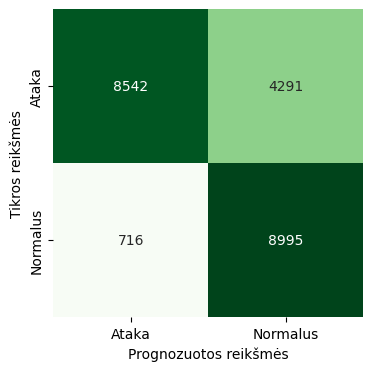

In [ ]:
plot_confusion_matrix(y_test, y_pred_nb)

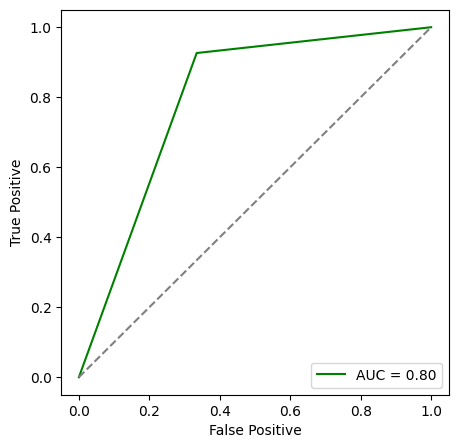

In [ ]:
plot_auc(y_test, y_pred_nb)

In [ ]:
print(classification_report(y_test, y_pred_nb, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.92      0.67      0.77     12833
    Normalus       0.68      0.93      0.78      9711

    accuracy                           0.78     22544
   macro avg       0.80      0.80      0.78     22544
weighted avg       0.82      0.78      0.78     22544



## Decision Tree

### Base parameters

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_fs, y_train)

y_pred_dt = dt_model.predict(X_test_fs)
calculate_results(y_test, y_pred_dt)

{'accuracy': 80.62455642299503,
 'precision': 0.851065567320555,
 'recall': 0.8062455642299503,
 'f1': 0.8053235732110873}

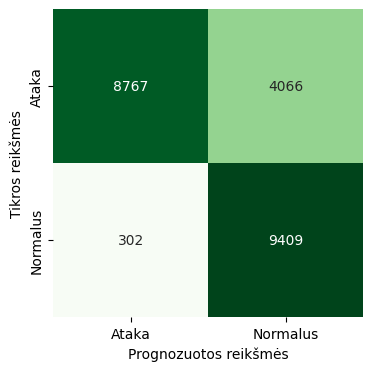

In [ ]:
plot_confusion_matrix(y_test, y_pred_dt)

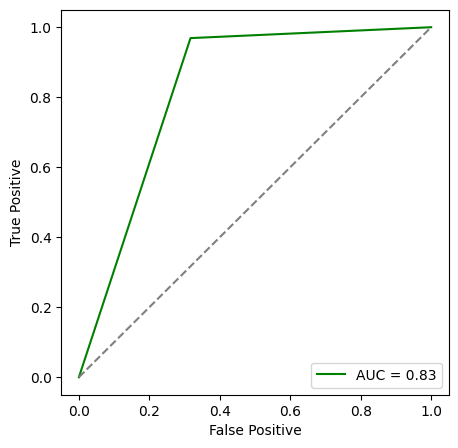

In [ ]:
plot_auc(y_test, y_pred_dt)

In [ ]:
print(classification_report(y_test, y_pred_dt, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.97      0.68      0.80     12833
    Normalus       0.70      0.97      0.81      9711

    accuracy                           0.81     22544
   macro avg       0.83      0.83      0.81     22544
weighted avg       0.85      0.81      0.81     22544



### Fine-tuning

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def objective_dt(trial):
  param = {
      'max_depth': trial.suggest_int("max_depth", 5, X_train_fs.shape[1]),
      'min_samples_split': trial.suggest_int("min_samples_split", 2, 20),
      'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 20),
  }

  model = DecisionTreeClassifier(**param)
  model.fit(X_train_fs, y_train)
  y_pred = model.predict(X_test_fs)
  return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective_dt, n_trials=50)

[I 2023-04-18 10:23:55,823] A new study created in memory with name: no-name-b2677f85-0200-4728-a02d-ebe26107669d
[I 2023-04-18 10:24:07,550] Trial 0 finished with value: 0.7736870120652946 and parameters: {'max_depth': 24, 'min_samples_split': 15, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7736870120652946.
[I 2023-04-18 10:24:10,953] Trial 1 finished with value: 0.7806511710432931 and parameters: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.7806511710432931.
[I 2023-04-18 10:24:20,211] Trial 2 finished with value: 0.7981281050390348 and parameters: {'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.7981281050390348.
[I 2023-04-18 10:24:31,999] Trial 3 finished with value: 0.767876153300213 and parameters: {'max_depth': 23, 'min_samples_split': 15, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.7981281050390348.
[I 2023-04-18 10:24:36,037] Trial 4 finished with value: 0.77

In [ ]:
study.best_params

{'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 2}

In [ ]:
model_dt = DecisionTreeClassifier(**study.best_params)
model_dt.fit(X_train_fs, y_train)

y_pred_dt = model_dt.predict(X_test_fs)
calculate_results(y_test, y_pred_dt)

{'accuracy': 81.15684882895671,
 'precision': 0.8544190578324893,
 'recall': 0.8115684882895671,
 'f1': 0.8108348990875134}

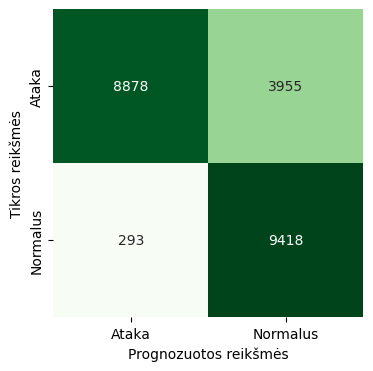

In [ ]:
plot_confusion_matrix(y_test, y_pred_dt)

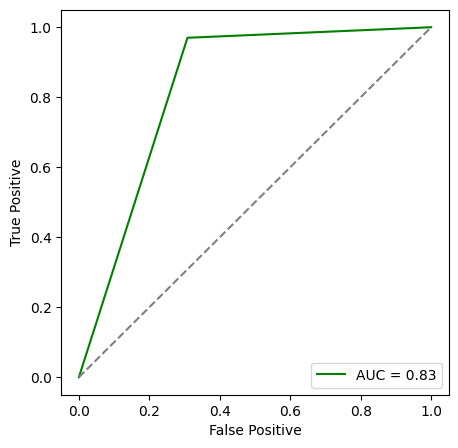

In [ ]:
plot_auc(y_test, y_pred_dt)

In [ ]:
print(classification_report(y_test, y_pred_dt, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.97      0.69      0.81     12833
    Normalus       0.70      0.97      0.82      9711

    accuracy                           0.81     22544
   macro avg       0.84      0.83      0.81     22544
weighted avg       0.85      0.81      0.81     22544



In [ ]:
pickle.dump(model_dt, open(BASE+'models/feature_selected/DT.sav', 'wb'))

## Random Forest

### Base parameters

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
rf_model.fit(X_train_fs, y_train)

y_pred_rf = rf_model.predict(X_test_fs)
calculate_results(y_test, y_pred_rf)

{'accuracy': 76.53921220723917,
 'precision': 0.8270018345541292,
 'recall': 0.7653921220723917,
 'f1': 0.7622769296295863}

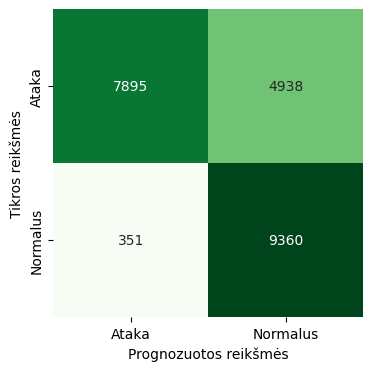

In [ ]:
plot_confusion_matrix(y_test, y_pred_rf)

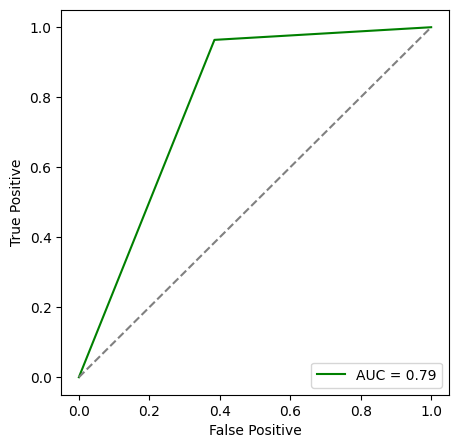

In [ ]:
plot_auc(y_test, y_pred_rf)

In [ ]:
print(classification_report(y_test, y_pred_rf, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.96      0.62      0.75     12833
    Normalus       0.65      0.96      0.78      9711

    accuracy                           0.77     22544
   macro avg       0.81      0.79      0.76     22544
weighted avg       0.83      0.77      0.76     22544



### Fine-tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def objective_rf(trial):
  param = {
      'n_estimators': trial.suggest_int('n_estimators', 5, 26),
      'max_depth': trial.suggest_int('max_depth', 4, 50),
      'min_samples_split': trial.suggest_int('min_samples_split', 2, 150),
      'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 60),
  }

  model = RandomForestClassifier(**param)
  model.fit(X_train_fs, y_train)
  y_pred = model.predict(X_test_fs)
  return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=50)

[I 2023-04-18 11:22:18,186] A new study created in memory with name: no-name-8173f940-3a52-437d-84fe-36e336c7acf0
[I 2023-04-18 11:22:39,389] Trial 0 finished with value: 0.7595812633073101 and parameters: {'n_estimators': 22, 'max_depth': 11, 'min_samples_split': 47, 'min_samples_leaf': 35}. Best is trial 0 with value: 0.7595812633073101.
[I 2023-04-18 11:22:59,444] Trial 1 finished with value: 0.7666784953867991 and parameters: {'n_estimators': 22, 'max_depth': 40, 'min_samples_split': 10, 'min_samples_leaf': 29}. Best is trial 1 with value: 0.7666784953867991.
[I 2023-04-18 11:23:07,851] Trial 2 finished with value: 0.7621096522356281 and parameters: {'n_estimators': 9, 'max_depth': 42, 'min_samples_split': 9, 'min_samples_leaf': 17}. Best is trial 1 with value: 0.7666784953867991.
[I 2023-04-18 11:23:28,030] Trial 3 finished with value: 0.7401082327892122 and parameters: {'n_estimators': 25, 'max_depth': 12, 'min_samples_split': 93, 'min_samples_leaf': 13}. Best is trial 1 with val

In [ ]:
study.best_params

{'n_estimators': 15,
 'max_depth': 20,
 'min_samples_split': 122,
 'min_samples_leaf': 48}

In [ ]:
model_rf = RandomForestClassifier(**study.best_params)
model_rf.fit(X_train_fs, y_train)

y_pred_rf = model_rf.predict(X_test_fs)
calculate_results(y_test, y_pred_dt)

{'accuracy': 81.15684882895671,
 'precision': 0.8544190578324893,
 'recall': 0.8115684882895671,
 'f1': 0.8108348990875134}

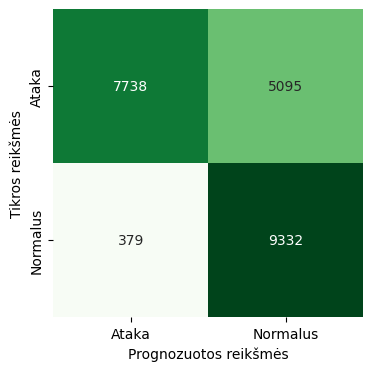

In [ ]:
plot_confusion_matrix(y_test, y_pred_rf)

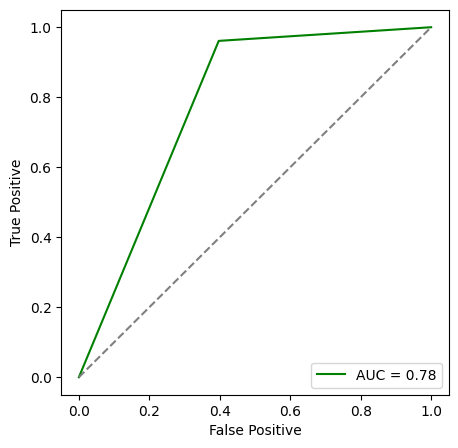

In [ ]:
plot_auc(y_test, y_pred_rf)

In [ ]:
print(classification_report(y_test, y_pred_rf, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.95      0.60      0.74     12833
    Normalus       0.65      0.96      0.77      9711

    accuracy                           0.76     22544
   macro avg       0.80      0.78      0.76     22544
weighted avg       0.82      0.76      0.75     22544



In [ ]:
pickle.dump(y_pred_rf, open(BASE+'models/feature_selected/RF.sav', 'wb'))

## XGBoost Classifier

### Base parameters

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train_fs, y_train)

y_pred_xgb = xgb_model.predict(X_test_fs)
calculate_results(y_test, y_pred_xgb)

{'accuracy': 78.32682753726047,
 'precision': 0.8415446819498698,
 'recall': 0.7832682753726047,
 'f1': 0.7808918038663565}

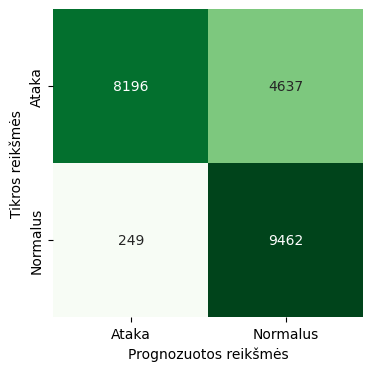

In [ ]:
plot_confusion_matrix(y_test, y_pred_xgb)

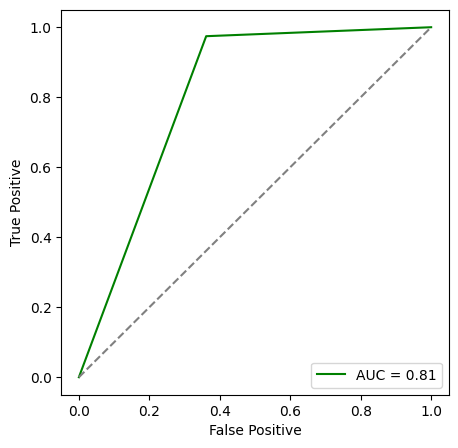

In [ ]:
plot_auc(y_test, y_pred_xgb)

In [ ]:
print(classification_report(y_test, y_pred_xgb, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.97      0.64      0.77     12833
    Normalus       0.67      0.97      0.79      9711

    accuracy                           0.78     22544
   macro avg       0.82      0.81      0.78     22544
weighted avg       0.84      0.78      0.78     22544



### Fine-tuning

In [ ]:
from xgboost import XGBClassifier

def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000)
    }
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2023-04-18 13:35:41,111] A new study created in memory with name: no-name-210dc201-0b16-4afc-8616-70a76356329b
[I 2023-04-18 13:37:44,190] Trial 0 finished with value: 0.7827803406671399 and parameters: {'max_depth': 98, 'learning_rate': 0.31399777051362154, 'n_estimators': 467, 'min_child_weight': 7, 'gamma': 0.1288544475050512, 'subsample': 0.8276359628188866, 'colsample_bytree': 0.5214517920810753, 'reg_alpha': 0.617966912861336, 'reg_lambda': 0.10344792857959861, 'random_state': 910}. Best is trial 0 with value: 0.7827803406671399.
[I 2023-04-18 13:41:25,736] Trial 1 finished with value: 0.7845546486870121 and parameters: {'max_depth': 12, 'learning_rate': 0.09475810391926492, 'n_estimators': 413, 'min_child_weight': 5, 'gamma': 0.6433659958520703, 'subsample': 0.9672665302417266, 'colsample_bytree': 0.952499954219022, 'reg_alpha': 0.3178545439402394, 'reg_lambda': 0.16110016728213458, 'random_state': 145}. Best is trial 1 with value: 0.7845546486870121.
[I 2023-04-18 13:42:04,4

In [ ]:
study.best_params

{'max_depth': 90,
 'learning_rate': 0.9283874813237036,
 'n_estimators': 482,
 'min_child_weight': 3,
 'gamma': 0.9311643221679913,
 'subsample': 0.13630500906893117,
 'colsample_bytree': 0.5796192764244217,
 'reg_alpha': 0.846744902825593,
 'reg_lambda': 0.4091888336539419,
 'random_state': 905}

In [ ]:
model_xgb = XGBClassifier(**study.best_params)
model_xgb.fit(X_train_fs, y_train)

y_pred_xgb = model_xgb.predict(X_test_fs)
calculate_results(y_test, y_pred_xgb)

{'accuracy': 79.44020581973031,
 'precision': 0.832823563109662,
 'recall': 0.794402058197303,
 'f1': 0.7938619932569366}

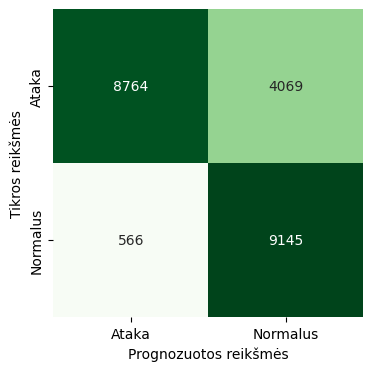

In [ ]:
plot_confusion_matrix(y_test, y_pred_xgb)

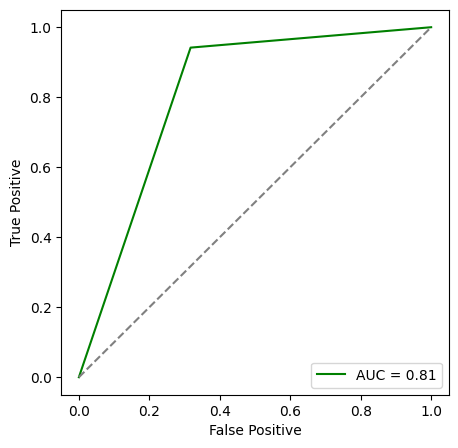

In [ ]:
plot_auc(y_test, y_pred_xgb)

In [ ]:
print(classification_report(y_test, y_pred_xgb, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.94      0.68      0.79     12833
    Normalus       0.69      0.94      0.80      9711

    accuracy                           0.79     22544
   macro avg       0.82      0.81      0.79     22544
weighted avg       0.83      0.79      0.79     22544



In [ ]:
pickle.dump(model_xgb, open(BASE+'models/feature_selected/XGB.sav', 'wb'))

## TensorFlow Decision Forest

In [ ]:
!pip install tensorflow tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 31.3 MB/s eta 0:00:00


### Base parameters

In [ ]:
tr_df = pd.DataFrame(X_train_fs)
te_df = pd.DataFrame(X_test_fs)

tr_df['attack'] = y_train
te_df['attack'] = y_test

In [ ]:
cols = []

for i in tr_df.columns[:-1]:
  cols.append('feature_' + str(i))

In [ ]:
cols.append('attack')
tr_df.columns = cols
te_df.columns = cols

In [ ]:
import tensorflow_decision_forests as tfdf

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(tr_df, label="attack")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(te_df, label="attack")

tfdf_model = tfdf.keras.RandomForestModel()
tfdf_model.fit(train_ds)

Use /tmp/tmp9achv349 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:21.160405. Found 125973 examples.
Training model...
Model trained in 0:03:02.771945
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [ ]:
tfdf_model.save(BASE+'models/feature_selected/tfdf_model/')

In [ ]:
y_pred_tdfd = tfdf_model.predict(test_ds)
y_pred_tfdf_round = np.round(y_pred_tdfd)
calculate_results(y_test, y_pred_tfdf_round)

23/23 [==============================] - 2s 73ms/step


{'accuracy': 76.26419446415898,
 'precision': 0.826202100885239,
 'recall': 0.7626419446415897,
 'f1': 0.7592467982830797}

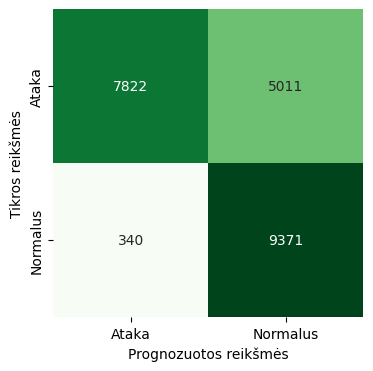

In [ ]:
plot_confusion_matrix(y_test, y_pred_tfdf_round)

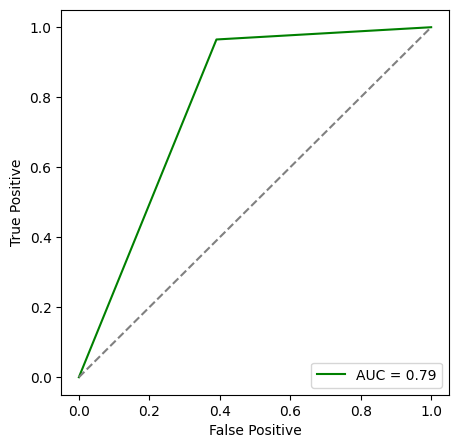

In [ ]:
plot_auc(y_test, y_pred_tfdf_round)

## Neural Networks

In [ ]:
X_train_lstm = np.reshape(X_train_fs, (X_train_fs.shape[0], 1, X_train_fs.shape[1]))
X_test_lstm = np.reshape(X_test_fs, (X_test_fs.shape[0], 1, X_test_fs.shape[1]))

### LSTM

In [ ]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(1, X_train_lstm.shape[2])),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=10,
                              batch_size=32, validation_split=.2)

Epoch 1/10
3150/3150 [==============================] - 47s 13ms/step - loss: 0.0622 - accuracy: 0.9787 - val_loss: 0.0231 - val_accuracy: 0.9935
Epoch 2/10
3150/3150 [==============================] - 29s 9ms/step - loss: 0.0264 - accuracy: 0.9915 - val_loss: 0.0215 - val_accuracy: 0.9942
Epoch 3/10
3150/3150 [==============================] - 46s 15ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.0149 - val_accuracy: 0.9960
Epoch 4/10
3150/3150 [==============================] - 29s 9ms/step - loss: 0.0182 - accuracy: 0.9945 - val_loss: 0.0134 - val_accuracy: 0.9964
Epoch 5/10
3150/3150 [==============================] - 28s 9ms/step - loss: 0.0167 - accuracy: 0.9949 - val_loss: 0.0133 - val_accuracy: 0.9962
Epoch 6/10
3150/3150 [==============================] - 29s 9ms/step - loss: 0.0152 - accuracy: 0.9954 - val_loss: 0.0127 - val_accuracy: 0.9969
Epoch 7/10
3150/3150 [==============================] - 41s 13ms/step - loss: 0.0142 - accuracy: 0.9956 - val_loss: 0.0121 - val

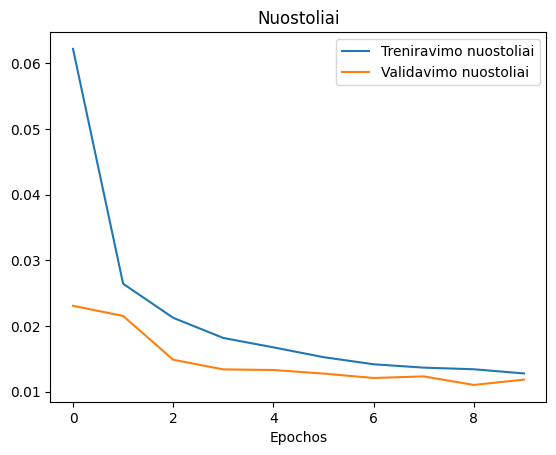

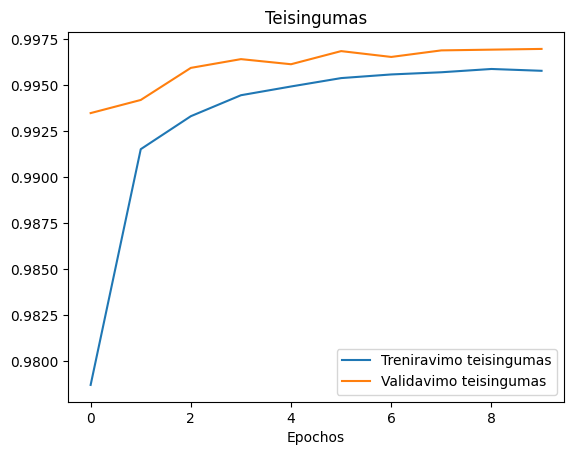

In [ ]:
plot_loss_curves(lstm_history)

In [ ]:
y_pred_lstm = lstm_model.predict(X_test_lstm, verbose=0)
calculate_results(y_test, tf.round(y_pred_lstm))

{'accuracy': 81.19233498935415,
 'precision': 0.8480457845382912,
 'recall': 0.8119233498935415,
 'f1': 0.811645960556385}

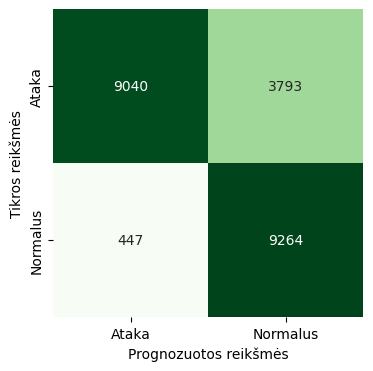

In [ ]:
plot_confusion_matrix(y_test, tf.round(y_pred_lstm))

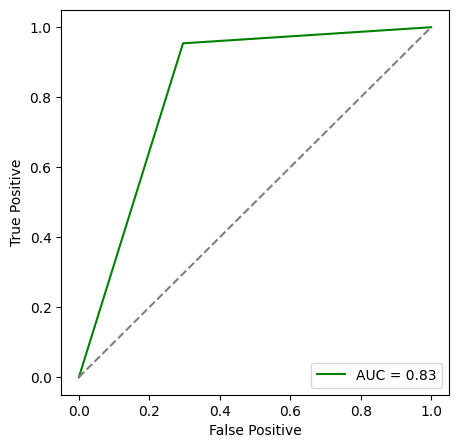

In [ ]:
plot_auc(y_test, tf.round(y_pred_lstm))

In [ ]:
print(classification_report(y_test, tf.round(y_pred_lstm),
                            target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.95      0.70      0.81     12833
    Normalus       0.71      0.95      0.81      9711

    accuracy                           0.81     22544
   macro avg       0.83      0.83      0.81     22544
weighted avg       0.85      0.81      0.81     22544



In [ ]:
lstm_model.save(BASE+'/feature_selected/lstm.h5')

### RNN

In [ ]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=True, input_shape=(1, X_train_lstm.shape[2])),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn_history = rnn_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32,
                            validation_split=.2)

Epoch 1/10
3150/3150 [==============================] - 32s 9ms/step - loss: 0.0537 - accuracy: 0.9810 - val_loss: 0.0275 - val_accuracy: 0.9908
Epoch 2/10
3150/3150 [==============================] - 20s 6ms/step - loss: 0.0305 - accuracy: 0.9892 - val_loss: 0.0208 - val_accuracy: 0.9929
Epoch 3/10
3150/3150 [==============================] - 21s 7ms/step - loss: 0.0250 - accuracy: 0.9916 - val_loss: 0.0179 - val_accuracy: 0.9951
Epoch 4/10
3150/3150 [==============================] - 24s 8ms/step - loss: 0.0216 - accuracy: 0.9932 - val_loss: 0.0183 - val_accuracy: 0.9949
Epoch 5/10
3150/3150 [==============================] - 30s 10ms/step - loss: 0.0191 - accuracy: 0.9940 - val_loss: 0.0171 - val_accuracy: 0.9952
Epoch 6/10
3150/3150 [==============================] - 19s 6ms/step - loss: 0.0187 - accuracy: 0.9944 - val_loss: 0.0161 - val_accuracy: 0.9956
Epoch 7/10
3150/3150 [==============================] - 20s 6ms/step - loss: 0.0173 - accuracy: 0.9950 - val_loss: 0.0146 - val_a

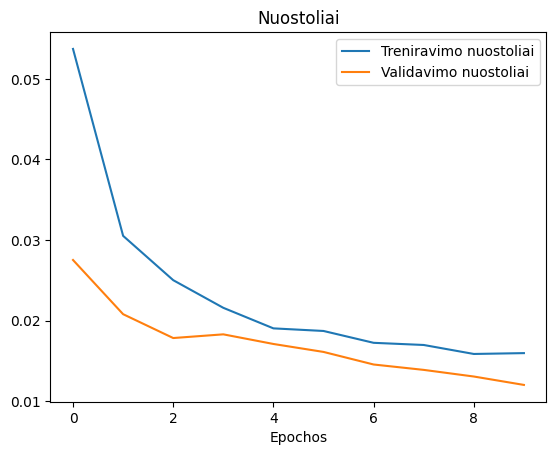

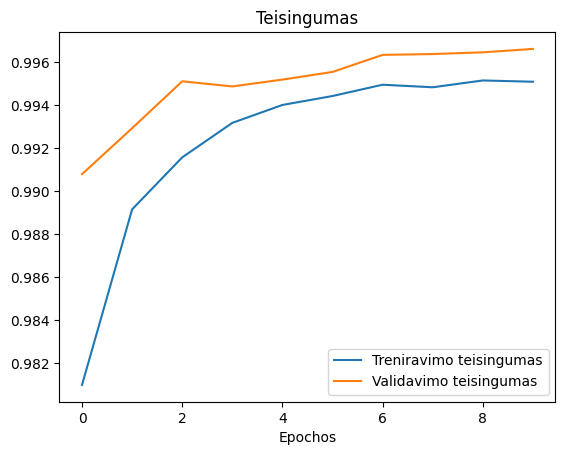

In [ ]:
plot_loss_curves(rnn_history)

In [ ]:
y_pred_rnn = rnn_model.predict(X_test_lstm, verbose=0)
calculate_results(y_test, tf.round(y_pred_rnn))

{'accuracy': 77.55056777856636,
 'precision': 0.8158665959674308,
 'recall': 0.7755056777856636,
 'f1': 0.774652086228877}

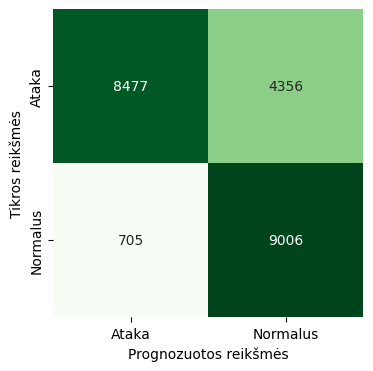

In [ ]:
plot_confusion_matrix(y_test, tf.round(y_pred_rnn))

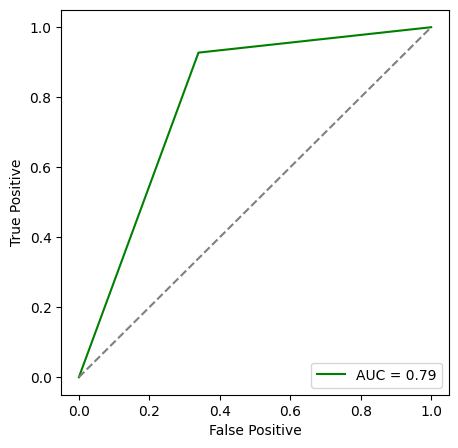

In [ ]:
plot_auc(y_test, tf.round(y_pred_rnn))

In [ ]:
print(classification_report(y_test, tf.round(y_pred_rnn),
                            target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.92      0.66      0.77     12833
    Normalus       0.67      0.93      0.78      9711

    accuracy                           0.78     22544
   macro avg       0.80      0.79      0.78     22544
weighted avg       0.82      0.78      0.77     22544



In [ ]:
rnn_model.save(BASE+'models/feature_selected/rnn.h5')

### MLP

In [ ]:
mlp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, input_dim=X_train_fs.shape[1], activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

mlp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mlp_history = mlp_model.fit(X_train_fs, y_train, epochs=10, batch_size=32, 
                            validation_split=.2)

Epoch 1/10
3150/3150 [==============================] - 22s 6ms/step - loss: 0.0517 - accuracy: 0.9853 - val_loss: 0.0194 - val_accuracy: 0.9952
Epoch 2/10
3150/3150 [==============================] - 21s 7ms/step - loss: 0.0186 - accuracy: 0.9944 - val_loss: 0.0150 - val_accuracy: 0.9958
Epoch 3/10
3150/3150 [==============================] - 13s 4ms/step - loss: 0.0147 - accuracy: 0.9956 - val_loss: 0.0124 - val_accuracy: 0.9966
Epoch 4/10
3150/3150 [==============================] - 9s 3ms/step - loss: 0.0128 - accuracy: 0.9961 - val_loss: 0.0124 - val_accuracy: 0.9962
Epoch 5/10
3150/3150 [==============================] - 11s 3ms/step - loss: 0.0120 - accuracy: 0.9963 - val_loss: 0.0119 - val_accuracy: 0.9967
Epoch 6/10
3150/3150 [==============================] - 7s 2ms/step - loss: 0.0113 - accuracy: 0.9965 - val_loss: 0.0116 - val_accuracy: 0.9969
Epoch 7/10
3150/3150 [==============================] - 9s 3ms/step - loss: 0.0106 - accuracy: 0.9966 - val_loss: 0.0109 - val_accur

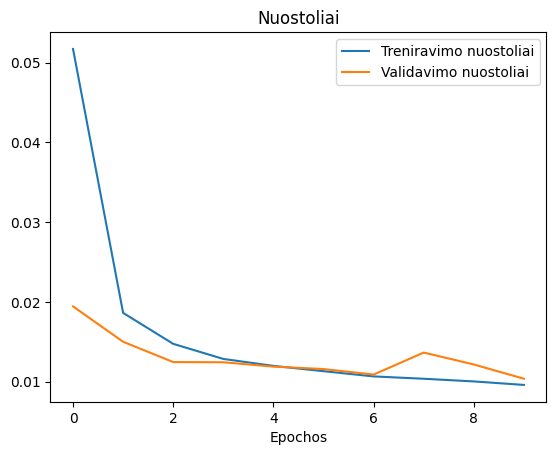

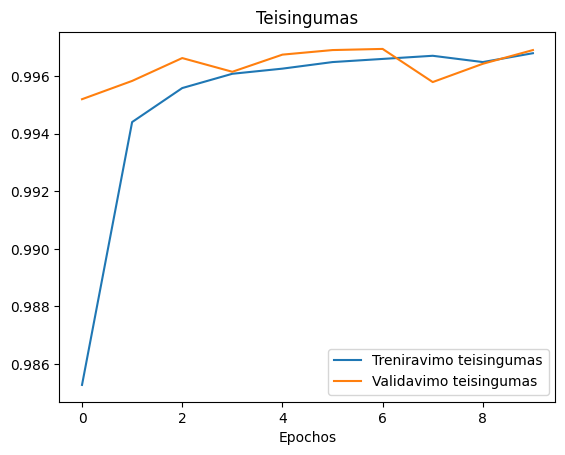

In [ ]:
plot_loss_curves(mlp_history)

In [ ]:
y_pred_mlp = mlp_model.predict(X_test_fs, verbose=0)
calculate_results(y_test, tf.round(y_pred_mlp))

{'accuracy': 78.9833215046132,
 'precision': 0.8247747645324827,
 'recall': 0.789833215046132,
 'f1': 0.789532090816724}

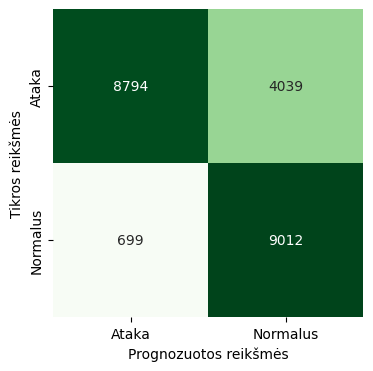

In [ ]:
plot_confusion_matrix(y_test, tf.round(y_pred_mlp))

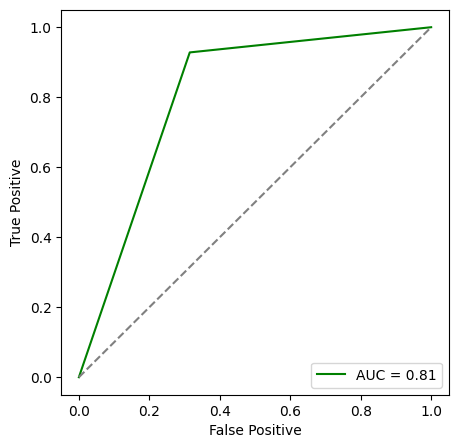

In [ ]:
plot_auc(y_test, tf.round(y_pred_mlp))

In [ ]:
print(classification_report(y_test, tf.round(y_pred_mlp),
                            target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.93      0.69      0.79     12833
    Normalus       0.69      0.93      0.79      9711

    accuracy                           0.79     22544
   macro avg       0.81      0.81      0.79     22544
weighted avg       0.82      0.79      0.79     22544



In [ ]:
mlp_model.save(BASE+'models/feature_selected/mlp.h5')

### 1D-CNN

In [ ]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, kernel_size=X_train_fs.shape[1], padding='same',
                           activation='relu', input_shape=(X_train_fs.shape[1], 1)),
    tf.keras.layers.MaxPool1D(5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_history = cnn_model.fit(X_train_fs, y_train, epochs=10, batch_size=32,
                            validation_split=.2)

Epoch 1/10
3150/3150 [==============================] - 26s 7ms/step - loss: 0.0428 - accuracy: 0.9846 - val_loss: 0.0192 - val_accuracy: 0.9947
Epoch 2/10
3150/3150 [==============================] - 19s 6ms/step - loss: 0.0227 - accuracy: 0.9923 - val_loss: 0.0145 - val_accuracy: 0.9954
Epoch 3/10
3150/3150 [==============================] - 19s 6ms/step - loss: 0.0185 - accuracy: 0.9939 - val_loss: 0.0136 - val_accuracy: 0.9960
Epoch 4/10
3150/3150 [==============================] - 17s 6ms/step - loss: 0.0179 - accuracy: 0.9941 - val_loss: 0.0142 - val_accuracy: 0.9958
Epoch 5/10
3150/3150 [==============================] - 19s 6ms/step - loss: 0.0166 - accuracy: 0.9945 - val_loss: 0.0122 - val_accuracy: 0.9960
Epoch 6/10
3150/3150 [==============================] - 19s 6ms/step - loss: 0.0162 - accuracy: 0.9947 - val_loss: 0.0136 - val_accuracy: 0.9955
Epoch 7/10
3150/3150 [==============================] - 20s 6ms/step - loss: 0.0149 - accuracy: 0.9953 - val_loss: 0.0123 - val_ac

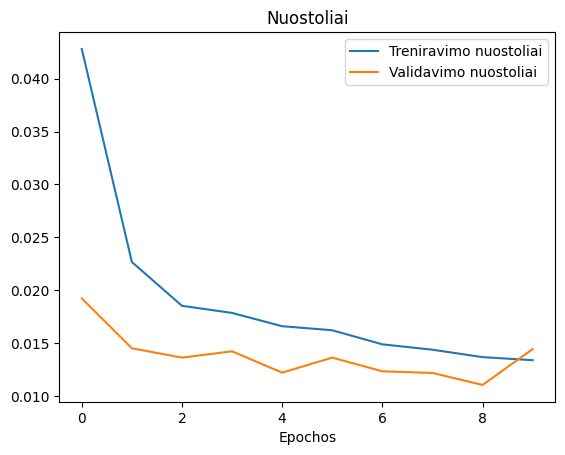

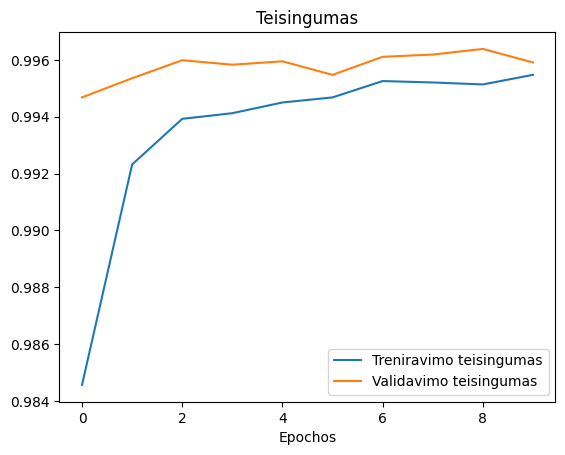

In [ ]:
plot_loss_curves(cnn_history)

In [ ]:
y_pred_cnn = cnn_model.predict(X_test_fs, verbose=0)
calculate_results(y_test, tf.round(y_pred_cnn))

{'accuracy': 81.43630234208659,
 'precision': 0.839511247521622,
 'recall': 0.8143630234208659,
 'f1': 0.814742854339704}

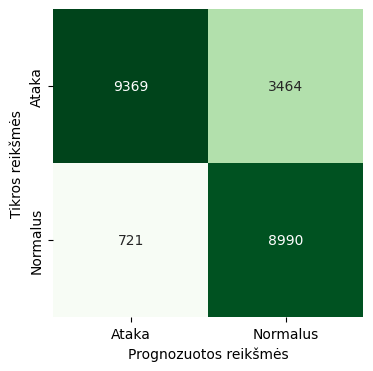

In [ ]:
plot_confusion_matrix(y_test, tf.round(y_pred_cnn))

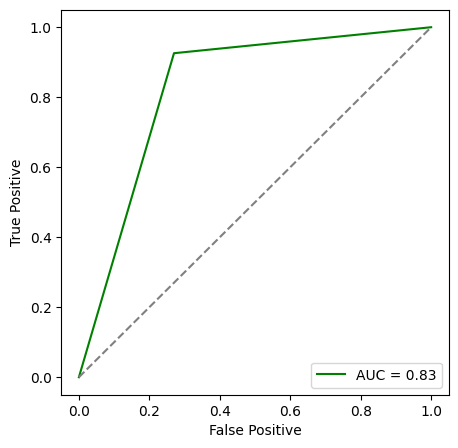

In [ ]:
plot_auc(y_test, tf.round(y_pred_cnn))

In [ ]:
print(classification_report(y_test, tf.round(y_pred_cnn),
                            target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.93      0.73      0.82     12833
    Normalus       0.72      0.93      0.81      9711

    accuracy                           0.81     22544
   macro avg       0.83      0.83      0.81     22544
weighted avg       0.84      0.81      0.81     22544



In [ ]:
cnn_model.save(BASE+'models/feature_selected/cnn.h5')  

# Train dataset: 80% for training, 20% for validation

In [ ]:
X, y = train_df.drop('attack', axis=1), train_df.attack

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=RANDOM_SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((100778, 54), (25195, 54), (100778,), (25195,))

## SVM

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(C=24.164, gamma=0.1331)
svc.fit(X_train, y_train)

pred_svc = svc.predict(X_test)
calculate_results(y_test, pred_svc)

{'accuracy': 99.70232188926374,
 'precision': 0.9970247968641485,
 'recall': 0.9970232188926375,
 'f1': 0.9970230217706461}

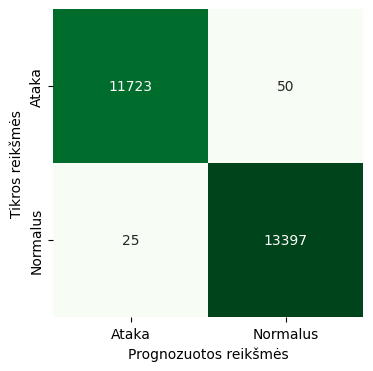

In [ ]:
plot_confusion_matrix(y_test, pred_svc)

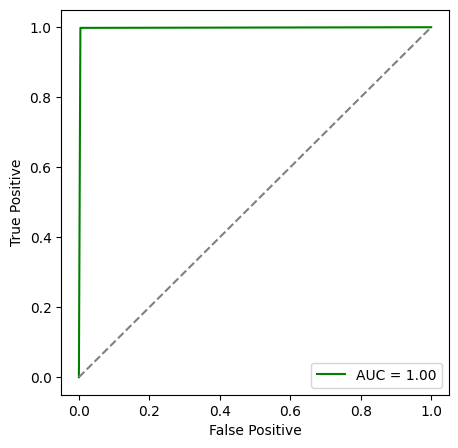

In [ ]:
plot_auc(y_test, pred_svc)

In [ ]:
print(classification_report(y_test, pred_svc, target_names=labels))

              precision    recall  f1-score   support

       Ataka       1.00      1.00      1.00     11773
    Normalus       1.00      1.00      1.00     13422

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



## RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
calculate_results(y_test, pred_rf)

{'accuracy': 99.88886683865846,
 'precision': 0.9988890534847052,
 'recall': 0.9988886683865846,
 'f1': 0.9988886333390502}

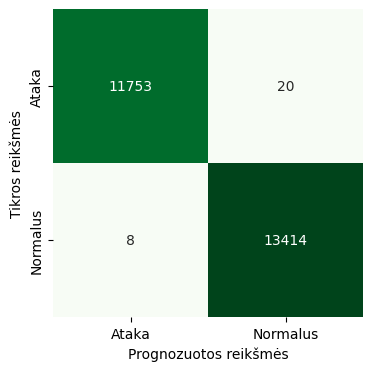

In [ ]:
plot_confusion_matrix(y_test, pred_rf)

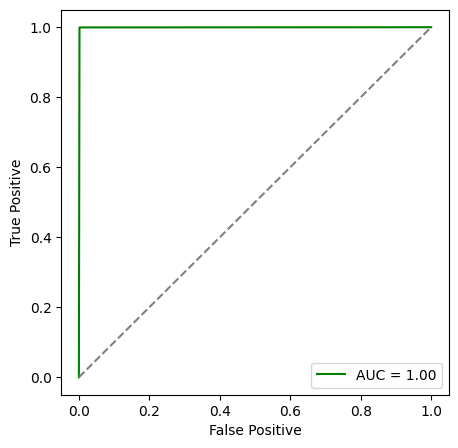

In [ ]:
plot_auc(y_test, pred_rf)

In [ ]:
print(classification_report(y_test, pred_rf, target_names=labels))

              precision    recall  f1-score   support

       Ataka       1.00      1.00      1.00     11773
    Normalus       1.00      1.00      1.00     13422

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



## NB

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train)

pred_nb = nb.predict(X_test)
calculate_results(y_test, pred_nb)

{'accuracy': 92.6731494344116,
 'precision': 0.9273299425497495,
 'recall': 0.926731494344116,
 'f1': 0.9267898851023694}

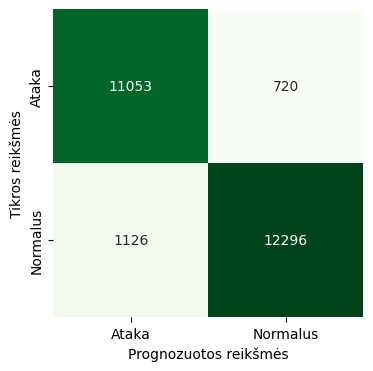

In [ ]:
plot_confusion_matrix(y_test, pred_nb)

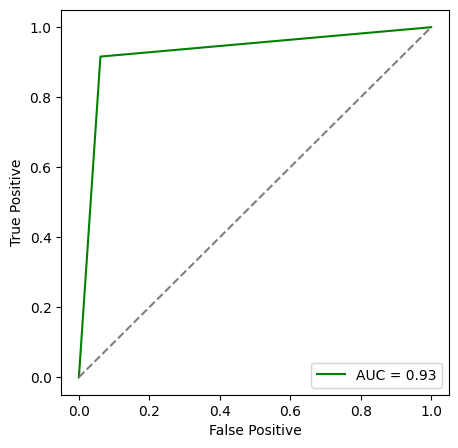

In [ ]:
plot_auc(y_test, pred_nb)

In [ ]:
print(classification_report(y_test, pred_nb, target_names=labels))

              precision    recall  f1-score   support

       Ataka       0.91      0.94      0.92     11773
    Normalus       0.94      0.92      0.93     13422

    accuracy                           0.93     25195
   macro avg       0.93      0.93      0.93     25195
weighted avg       0.93      0.93      0.93     25195

